# Libraries 

In [1]:
# Basic Libraries:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm


#Additional libraries: 
from scipy import stats
from pandas_profiling import ProfileReport #generates a report of the dataset in HTML 
from pathlib import Path
from matplotlib.colors import to_rgb, is_color_like #used to convert item_color using rgb
import tqdm #useful loading bar

# Cramer V:
import association_metrics as am # I use it to plot Cramer V correlations


#Sklearn:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import scale
from sklearn import metrics
from sklearn.preprocessing import minmax_scale


#RandomForest:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, plot_confusion_matrix


#XGBoosting:
import xgboost as xgb
from xgboost import plot_importance
import re
from datetime import datetime


#DecisionTree
from sklearn import tree
from dtreeviz.trees import * #it plots the path of a decision tree 

#Logit
from sklearn.linear_model import LogisticRegression

#Model Tuning:
from scipy.stats import randint, geom , loguniform, uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#Matplotlib Graph parameters: 
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

# INTRODUCTION 

The assignment of BADS is a predictive modeling task, which is a subset of data analytics that uses data mining techniques and probability to predict future outcomes. In essence, a model should be developed and applied to historical data; new, future data would then be used together with the model to make a future prediction. A Predictive modeling problem can also be described as a mathematical problem of approximating a mapping function (f) using independent variables (X)to output variables (y). 

In our scenario, the predictive model should be used and trained on a known dataset, where for every row, the target variable "return" is known ( its classes are given). After training, the model should be applied to new data to predict whether a customer is going to return the product purchased or not. The target variable comprises two discrete classes/labels: 0-negative class, which refers to the customer's action that decides to keep the product, and 1-positive class, which refers to the return of the product purchased by the customer. A situation where the algorithm has to predict a class/label, like in our scenario, is called Classification. It's a problem of
automatically assigning a label to an unlabeled example. In machine learning, a classification problem is solved by a classification learning algorithm. It's opposed to a Regression problem where the purpose is to predict a real-valued label, or target, given an unlabeled example. 

The objective of this notebook is to predict the future classes of the target variable return and create a model that, when making predictions, also minimizes costs for the merchant. Costs occur whenever the model predicts the wrong class; depending on the error, the cost will vary. 

In this notebook, the data preparation phase has been applied separately but in parallel to both the Known and Unknown datasets. In reality, the unknown dataset would represent the future information collected by e-commerce, which would then be used to predict the labels (0,1). It might thereby not be available together with the Known dataset. 

The notebook mainly comprises of two parts: a first section where the focus is on **EDA & Data Preparation**, and a second one where different models are tested, evaluated, tuned to choose the most suitable one for future predictions **( Model tuning & selection, Model Evaluation)**

**First section** 

1) **Explanatory Data Analysis( EDA )**: This section will show graphical representations of the variables in order to investigate the main characteristics of the variables and decide where to act in the next phase 
- *Pandas_profiling* is used to generate helpful insight on the nature of variables
- *Cardinality* of variables is explored
- *Multicollinearity* is explored by checking correlation using Pearson coefficient for numerical variables and Cramer V for categoricals
- *Probability Distribution* is observed for numerical variables since regression models are susceptible to this aspect
- Interaction between numeric and categoric variables is observed 

2) **Data Preparation**: 
- Here, *missing values* are handled by imputing the **mode** of the categorical variables with missing elements.
- Outliers are handled with a **clipping** procedure 
- More useful variables are obtained by the datetime original variables **user_dob** , **user_reg_date**, **order_date** , **delivery_date**
- Numerical variables item_price and time_delivery are normalized using log
- item_color is transformed using matplotlib colors functionalities *to_rgb*, *is_color_like* and lambda functions. A dictionary is created for all the colors which were not recognized by the *is_color_like* function
- item_size is converted in an attempt to make it more uniform, using a woman standardized german size scale 
- user_state is transformed to reduce cardinality by creating a dictionary with the north, central, south regions of Germany. 


**Second Section**
 
3) **Model Tuning and Selection**
- 4 different models are implemented and tested on the train set: Logit, DecisionTree, RandomForest, Xgboost
- RandomSearchCV is used to tune the primary hyperparameters for RandomeForest and XGBoost, which showed the highest AUC score and the lowest total costs

4) **Model Evaluation**
- Models are evaluated using the ROC curve and AUC score; in addition, a function to determine the total costs generated with the predictions is used to determine the model which scored the best in terms of minimization of costs.

In [2]:
#Known dataset
#file = (insert path)
df = pd.read_csv(file)

#Unknown dataset
#file = (insert path)
df_t = pd.read_csv(file)

### Convert variables in right types of data

In the lines below variables are switched to the right types of data. 

A distinction must be made between numeric and categoric features. A numeric feature is one for which every value has a different order of magnitude than others, which means that the measurement of the number actually has a numeric meaning; it can be distinguished a maximum, a greater and lower value, and a minimum. On the other hand, a categoric value comprises unique categories that are different from each other but can not be compared in terms of magnitude; categories can not be ordered numerically, and there is no greater or lower. (example: red hair is not greater or minor than blue hair, they can not be compared. On the other hand, five is greater than four )

- Datetime variables are stored as `datetime64`

- **Item_id, Brand_id, User_id** do not follow the order of magnitude rule; they can not be compared "numerically"; thus they should be considered as `category` type

- **item_size, item_color, user_title, user_state** are `category` type




source: https://socratic.org/questions/what-is-a-numerical-variable-and-what-is-a-categorical-variable

In [3]:
#Known Dataset

df['order_date'] = df['order_date'].astype('datetime64')
df['delivery_date']=df['delivery_date'].astype('datetime64')
df['return']=df['return'].astype('category') #should be a bool; for now we keep it as category
df['item_size']=df['item_size'].astype('category')
df['item_color']=df['item_color'].astype('category')
df['user_title']=df['user_title'].astype('category')
df['user_dob']=df['user_dob'].astype('datetime64')
df['user_state']=df['user_state'].astype('category')
df['user_reg_date']=df['user_reg_date'].astype('datetime64')

df['brand_id']=df['brand_id'].astype('category')
df['user_id']=df['user_id'].astype('category')
df['item_id']=df['item_id'].astype('category')


In [4]:
#Unknown Dataset

df_t['order_date'] = df_t['order_date'].astype('datetime64')
df_t['delivery_date']=df_t['delivery_date'].astype('datetime64')
df_t['item_size']=df_t['item_size'].astype('category')
df_t['item_color']=df_t['item_color'].astype('category')
df_t['user_title']=df_t['user_title'].astype('category')
df_t['user_dob']=df_t['user_dob'].astype('datetime64')
df_t['user_state']=df_t['user_state'].astype('category')
df_t['user_reg_date']=df_t['user_reg_date'].astype('datetime64')

df['brand_id']=df['brand_id'].astype('category')
df['user_id']=df['user_id'].astype('category')
df['item_id']=df['item_id'].astype('category')

# Explanatory Data Analysis Part 1

### Pandas Profiling

This helpful library generates a report of any dataset. For initial analysis, it gives a fast overview of variables, correlations ect, and gives a first direction of where to orient the work 

The report gives a fast hint to the main problems: high cardinality,  missing values (order_date and delivery_date, inconsistency of some variables like Item_size, unique values of some features (order_item_id), distributions, and also a correlation between feature using different approaches.

`pip install pandas-profiling`

In [5]:
if not Path('Pandas_Profiling_Report.html').exists():
    profile = ProfileReport(df, title='Pandas Profiling Report', duplicates=None)
    profile.to_file("Pandas_Profiling_Report.html")
    profile

### Cross cheking distributions of variables


The idea is to see how the distribution of the variables in the Known dataset compares to the distributions in the Unknown dataset. This procedure gives us evidence that some variables, for example, user_id, have different values in both datasets. When the model trains on the train set, it uses values that may not be found in the test set and would not know how to behave. 

Some variables can already be dropped from the dataset: item_id, order_item_id, and maybe also user_id. 

- Order_item_id represents the purchase order of the clients, the values in the known datasets continue in the Unknown sets; it is not a predictive variable

- User_id represents a specific customer identity. It is a categorical variable with very high cardinality. The problem is that it is not possible to have exactly the same customers in both the Unknown and Known datasets.  Checking the distributions in both datasets gives us confirmation. They do not match, especially on the high tails. 

- Brand_id represents the id of the single brands for which a product was purchased. It is a categorical variable with high cardinality. Interesting information is gathered here. Some brands might be more likely to be returned, and the opposite could be true. The distributions of the two match, which means categories should be similar.

- Item_id is categorical, with high cardinality. It represents the items purchased by the customers. Like brand_id, it could hide interesting information related to specific items purchased. Some could have more issues and may be linked to higher returns. However, the distributions do not precisely correspond, and many categories may only be found in one dataset. 

- item price is a numeric variable representing the values of the items purchased. As for categories, it is essential to make sure that the distributions of values are similar.  It looks like the variables behave similarly in the two sets

- User_dob is numeric and represents the date of birth of the customers. The distributions, as for item_price, match. 


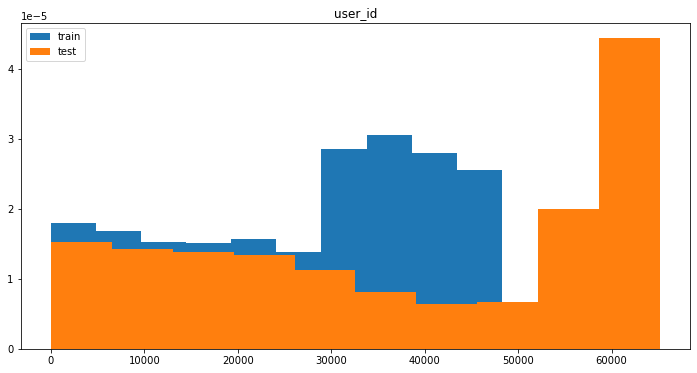

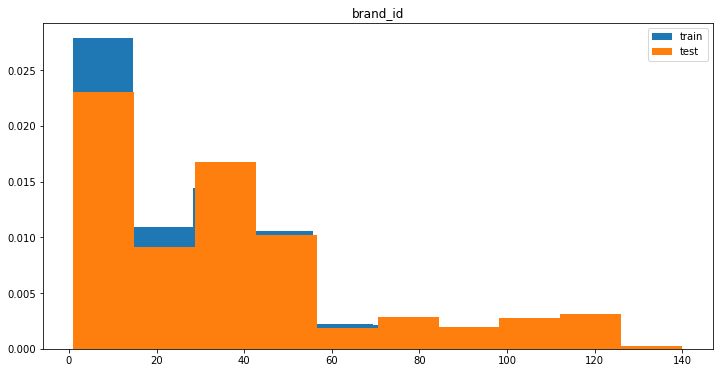

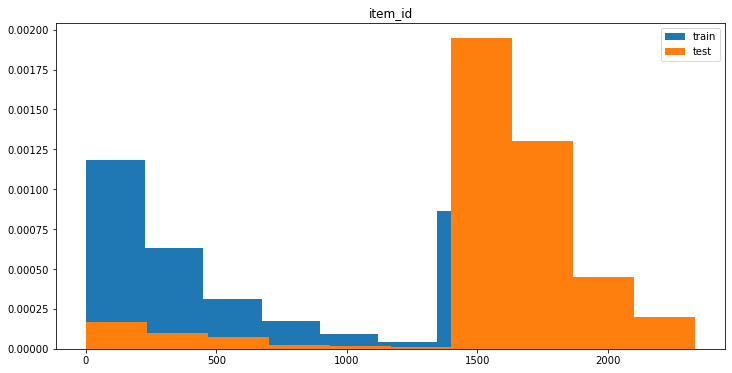

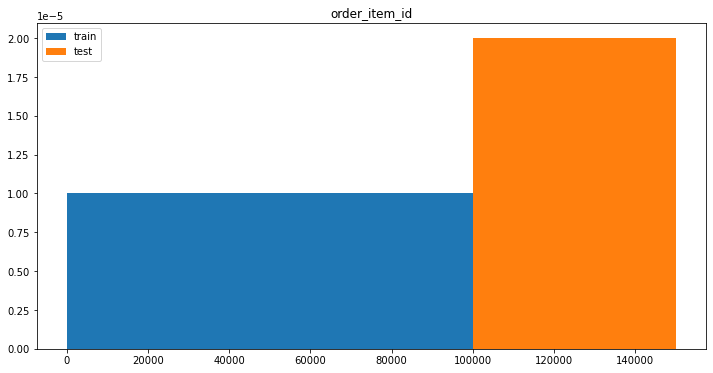

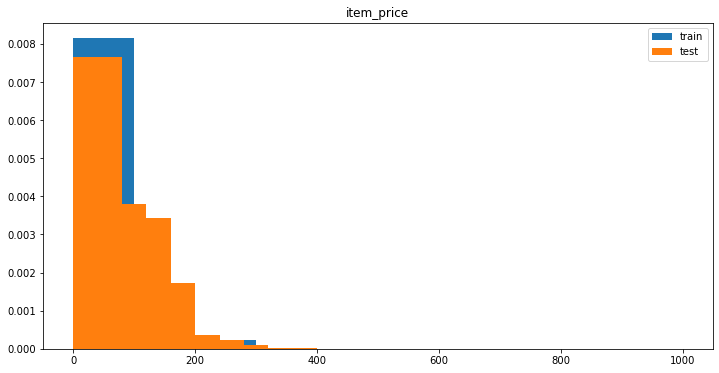

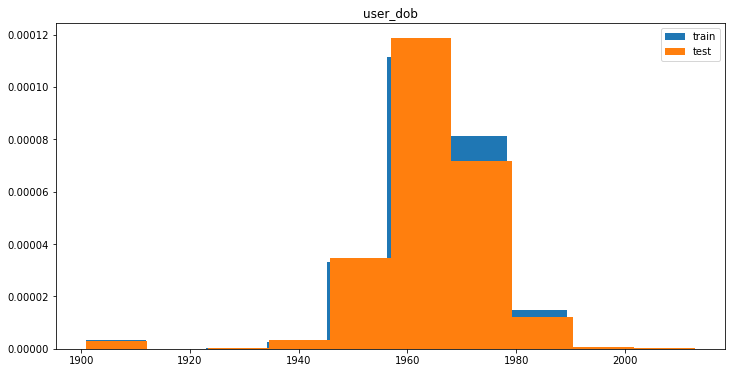

In [6]:
for c in ['user_id', 'brand_id', 'item_id','order_item_id','item_price','user_dob']:
    plt.title(c)
    plt.hist(df[c], label='train', density=True) #known and unknown datasets have different lenghts, therefore to increase interpretability,density should be set on True.
    plt.hist(df_t[c], label='test', density=True)
    plt.legend()
    plt.show()
    

### Cardinality 

Cardinality refers to the number of categories within a categorical variable. High cardinality can reduce the predictive power of variables and negatively impact the prediction of the model. In some cases, only specific categories can be helpful. In this notebook, some variables are transformed to reduce the cardinality. 

The `nunique()` method from pandas is useful to quantify cardinality, because it finds and counts the number of distinct values per variable. The method finds the number of unique values for both categorical and numerical variables. Here the focus is only on categoricals. 

By applying the mentioned method, some variables display high cardinality: **item_id**, **item_size**, **brand_id**, **Item_color**. To graphically show this, each feature is plotted on a histogram with a line to show the rare categories.  For example, because of the high number of categories, I used 2.5% as a threshold. More generally, a rare category is one that appears only in 5% of the observations.

In [7]:
investigate_variables=df[['user_title','item_color','user_state','brand_id','item_size']]

Text(0.5, 1.0, 'Cardinality')

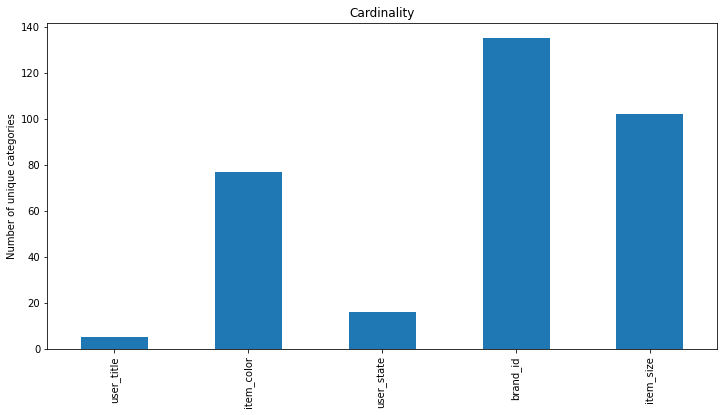

In [8]:
#plot of the cardinality of the variables in investigate_variables

investigate_variables.nunique(dropna=False).plot.bar(figsize=(12,6))
plt.ylabel('Number of unique categories')
plt.title('Cardinality')

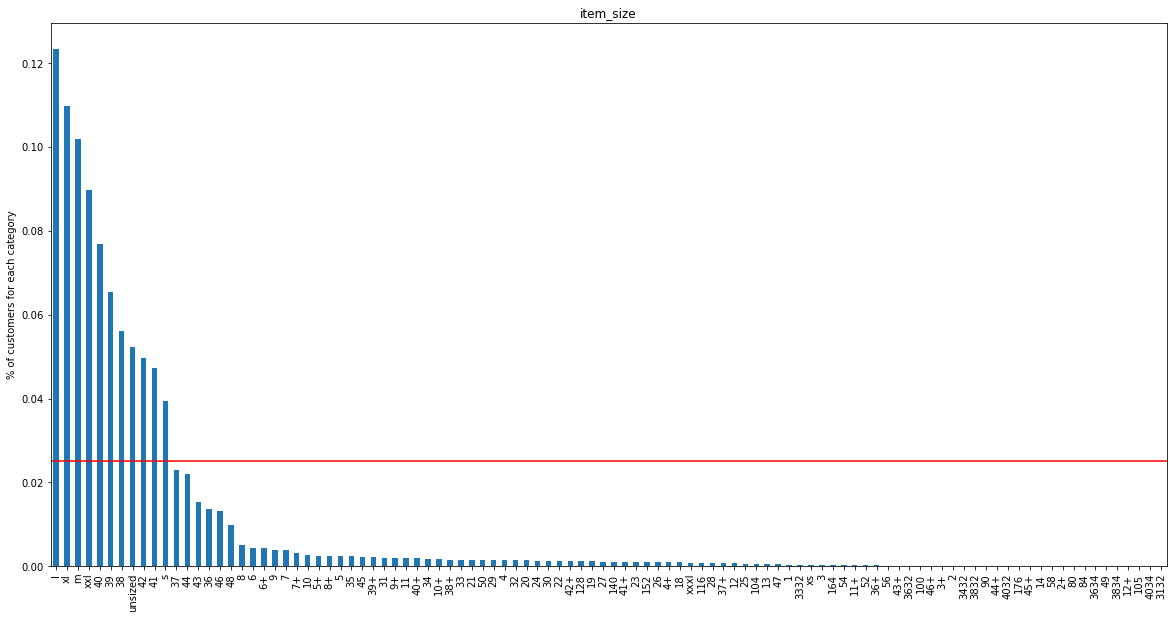

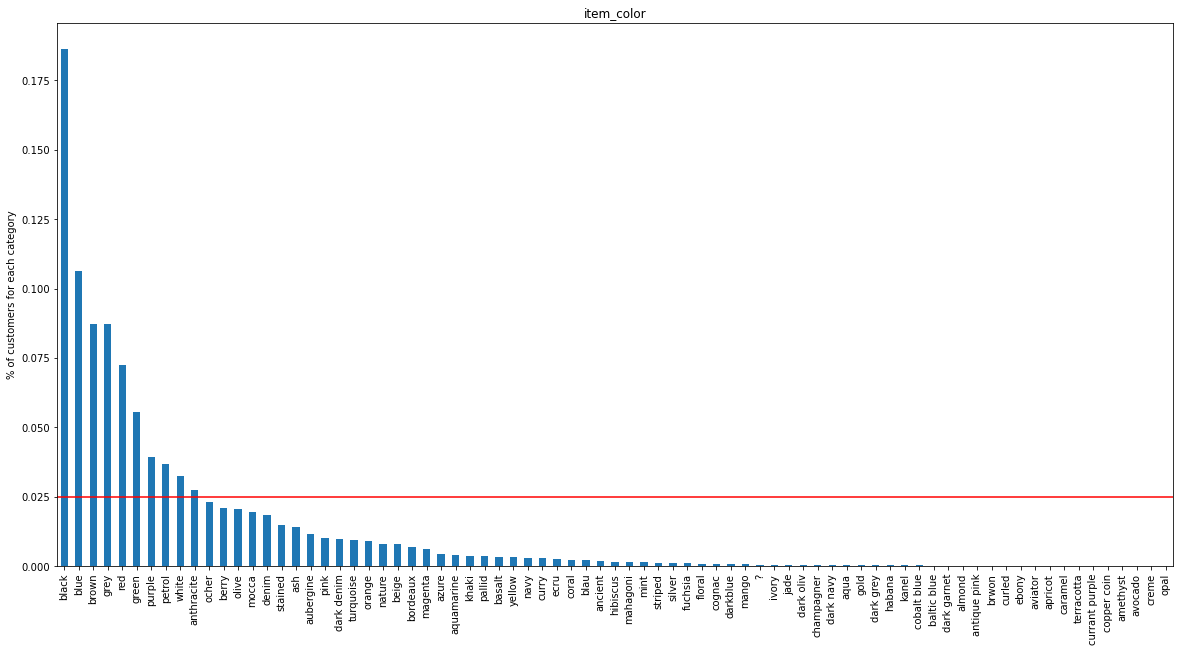

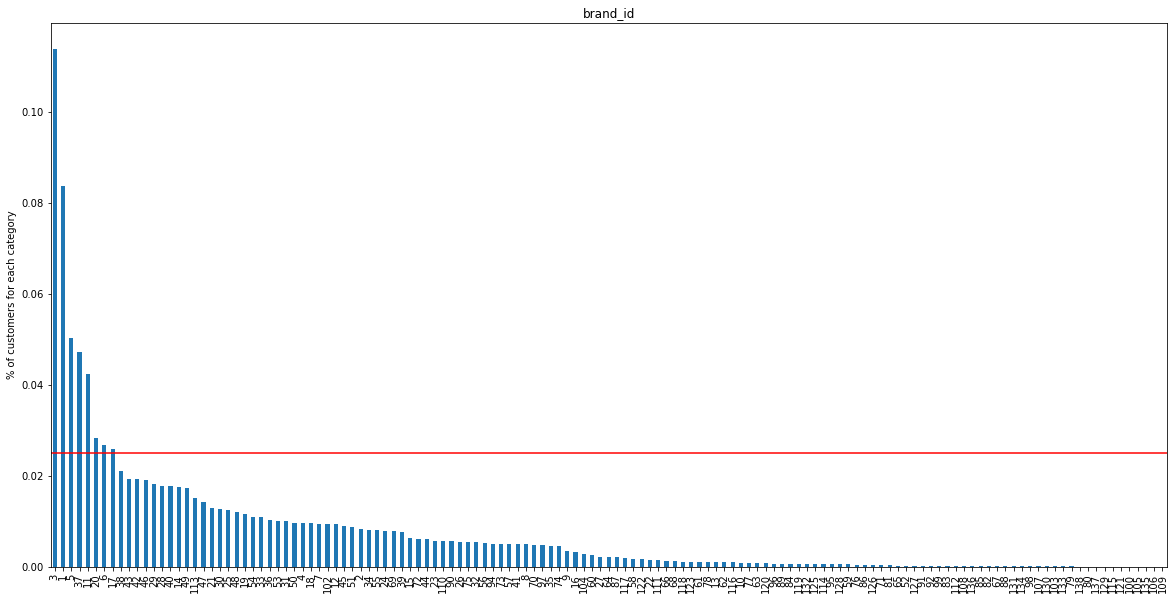

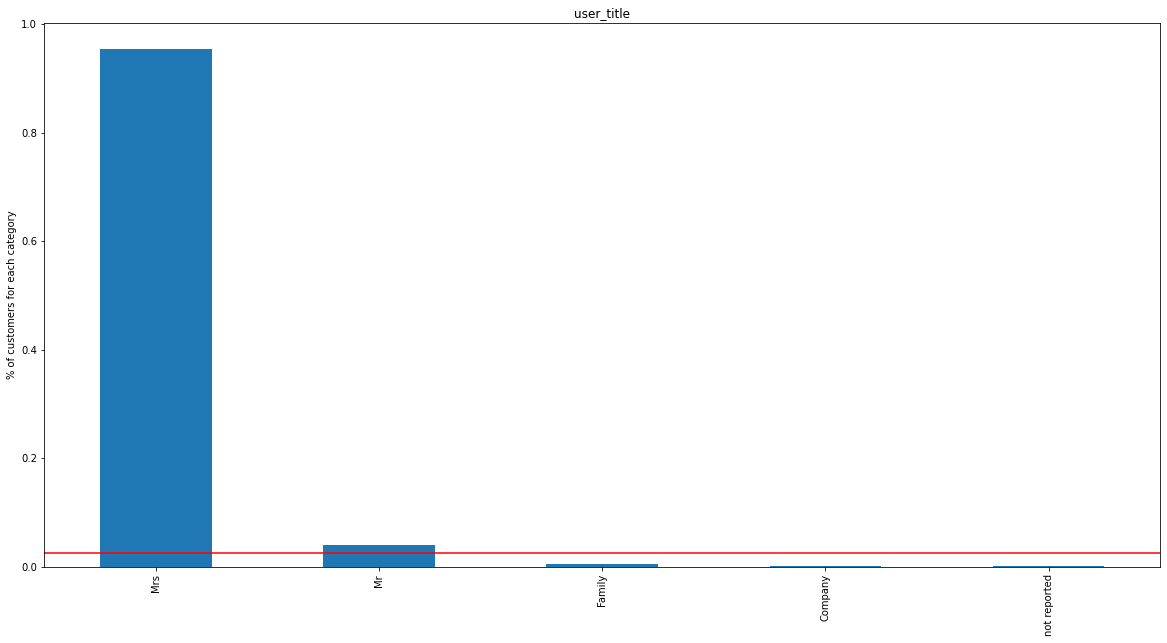

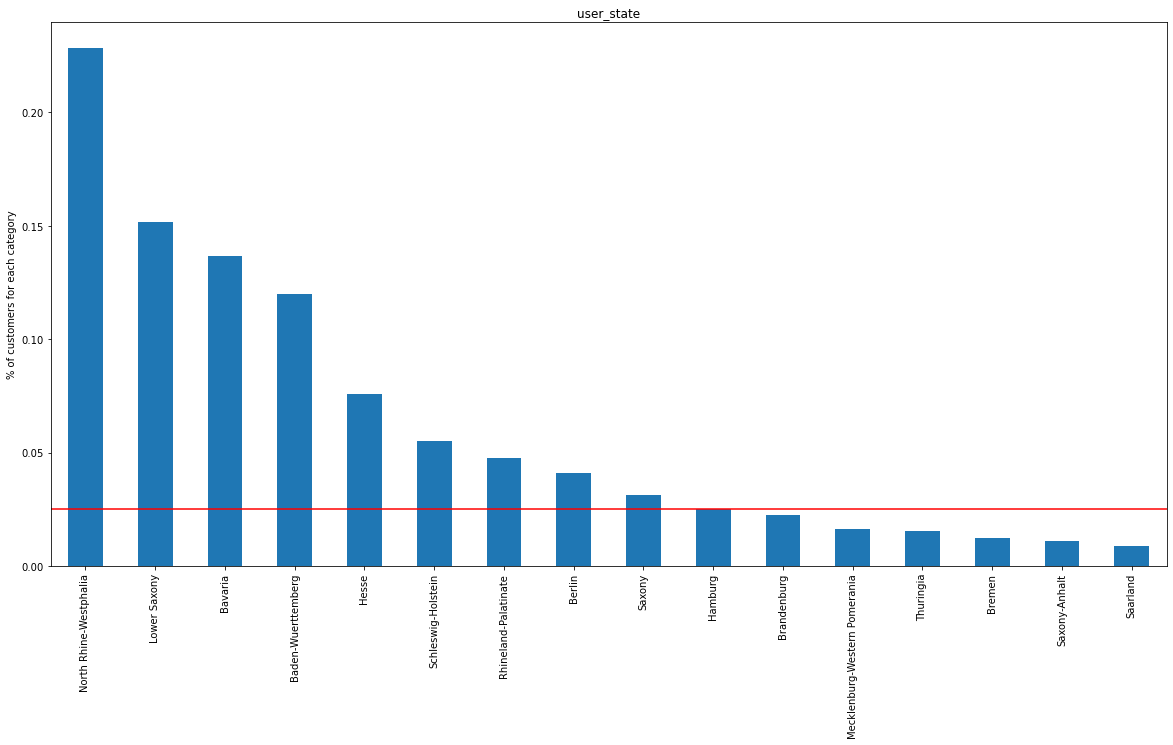

In [9]:
categoric_columns=df.select_dtypes('category').drop(['return','item_id','user_id'],axis=1)

for c in categoric_columns:  # for loop selects each element inside categoric_columns
    label_freq=df[c].value_counts()/len(df) # value_counts() returns the number of times a category in a variable occurs; it is then divided by the total number of observations
    fig=label_freq.sort_values(ascending=False).plot.bar(figsize=(20,10))
    fig.axhline(y=0.025,color='red') # descriptive threshold to separate more common categories from rare categories. 
    fig.set_ylabel('% of customers for each category')
    fig.set_title(c)
    plt.show()

As mentioned, **item_size**, but also **item_color**, and **brand_id** have many categoriers, some of which are extremely rare. Some of them may only be found on one dataset or the other, creating issues with the model. **user_title** looks good; **user_state** might need some feature engeeniring as well. 

### Cross checking relationship with target variable 

It is helpful to compare the independent features with the target variable return and see if we can spot some patterns related to the emergence of the discrete value 0 (the customer keeps the product ) and 1 ( customer returns the product). 

**user_reg_date**

some dates are particularly associated with more non returns (0), and therefore the variable could be more predictive of this label rather than (1). Further analysis is required to understand its usefulness. 

<AxesSubplot:xlabel='user_reg_date', ylabel='Count'>

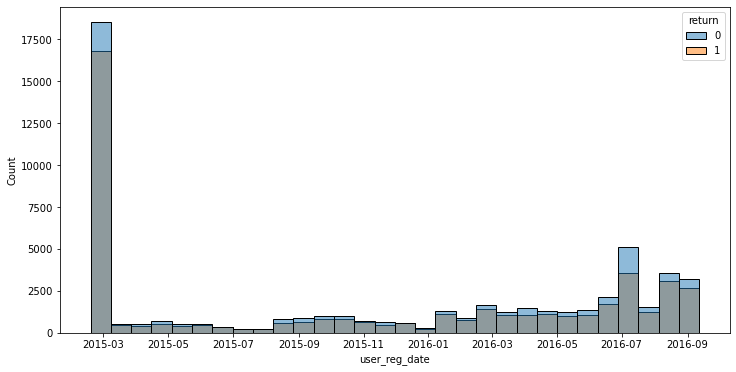

In [10]:
sns.histplot(df, x='user_reg_date', hue=df['return'], bins=30)

**item_price**

By looking at this graph, a pattern has emerged: items with lower item prices are associated with lower returns; items with higher prices are linked to more returns. For example, prices close to 0 ( low prices ) are linked to higher non returns. This effect can be helpful for the model to predict the label. 


<AxesSubplot:xlabel='item_price', ylabel='Count'>

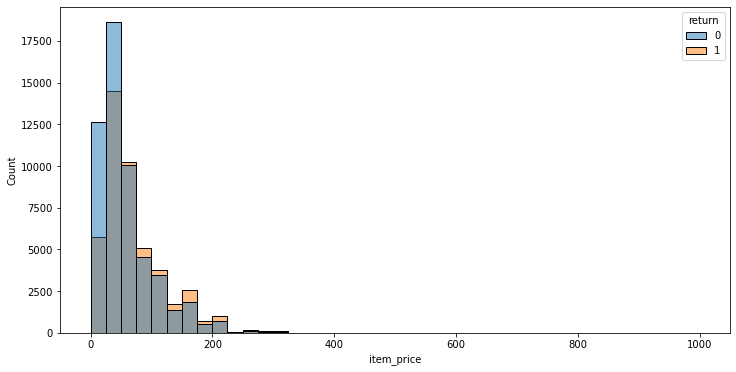

In [11]:
sns.histplot(df, x='item_price', hue='return', bins=40, )


**order_date & delivery_date**

The graphs below highlight an interesting finding: some dates in time are associated with more negative classes and vice versa. In the period around 2016/07/01, for example, 0 was more frequent than 1. Unfortunately, this information cannot be used because the last date recorded of order_date is 2016/09/15, while in the unknown set, the first date occurs later in time. The same thing is true also for delivery_date. A good feature can be extrapolated by counting the days between order_date ( the date when the order of purchase is set) and the delivery_date (date when the item was received): time to delivery 

<AxesSubplot:xlabel='order_date', ylabel='Count'>

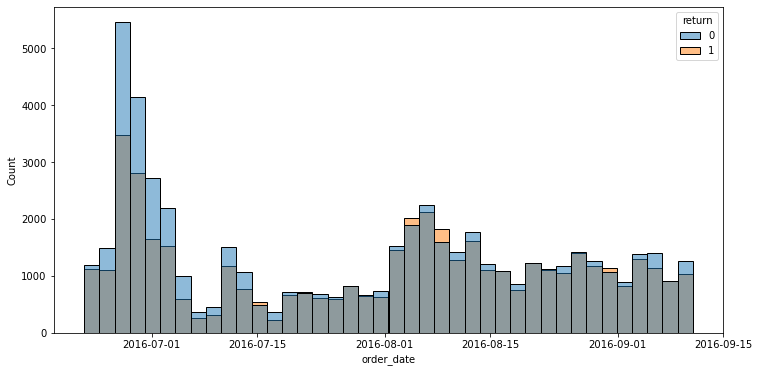

In [12]:
sns.histplot(df, x='order_date', hue=df['return'], bins=40)

<AxesSubplot:xlabel='delivery_date', ylabel='Count'>

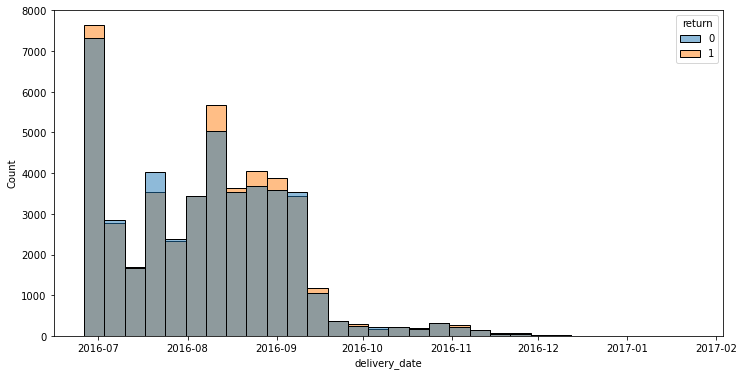

In [13]:
sns.histplot(df[df['delivery_date'] > datetime(day=1, month=1, year=2000)], x='delivery_date', hue=df['return'], bins=30)

#some outlier values interfere with plotting the histplot; to plot the variable only dates >  year 2000 are selected

**user_dob**

also quiet useful. There is a consistent imbalance between the 0 and 1 labels; more orientd toward the negative class. 

<AxesSubplot:xlabel='user_dob', ylabel='Count'>

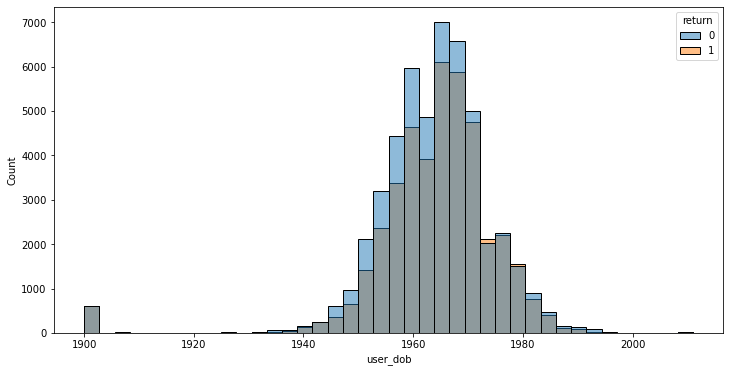

In [14]:
sns.histplot(x=pd.to_datetime(df['user_dob']).dt.year, hue=df['return'], bins=40)

**user_title and user_state**

From the graphs below, nothing of particular interest can be seen. The proportion of class distributions 0 and 1 looks similar, and might not help the model in predicting the correct class. In **user_title** the category company is more associated with the 1 label. But the category itself, as shown in the cardinality plots, is not frequent at all. Therefore it won't have a decisive influence on the model. 

In [15]:
def interaction_target(df,variable):
    interaction=df.groupby(['return',variable]).size().reset_index().pivot(columns='return', index=variable, values=0)
    interaction.div(interaction.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)

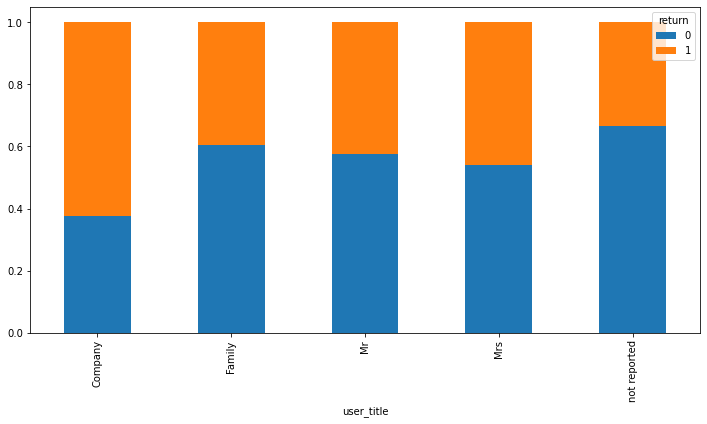

In [16]:
interaction_target(df, 'user_title')

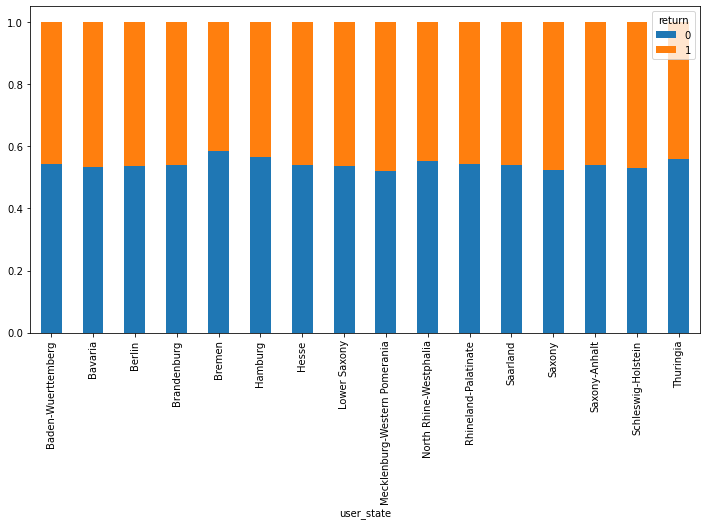

In [17]:
interaction_target(df, 'user_state')

# DATA PREPARATION Part 1

### Handle missing values

Missing values are common elements of any dataset.In this notebook, missing values are replaced with the *modes* ( because only date variables have missing elements ) using the **imputation technique**, which consists of replacing missing values of a feature with an average value of the feature in the dataset. The mode imputation is normally used with categorical features. Across the whole notebook, an important objective was to preserve the information of the dataset. The model, in general, can do better if more information is available for training. 

Steps followed: 


1) It is first checked if and where there are missing values.  

2) A seaborn heatmap plot is used to localize missing values visually. In our case, both the Known and Unknown datasets have missing values concentrated in the same columns: **user_dob** and **delivery_date**

3) Next, the missing values are replaced with their modes. It is used the mode because **delivery_date** and **user_dob** are datetime variables

4) Another heatmap is plotted to check if  procedure was successful 

**source:** [machinelearning mastery](https://machinelearningmastery.com/statistical-imputation-for-missing-values-in-machine-learning/)

<AxesSubplot:>

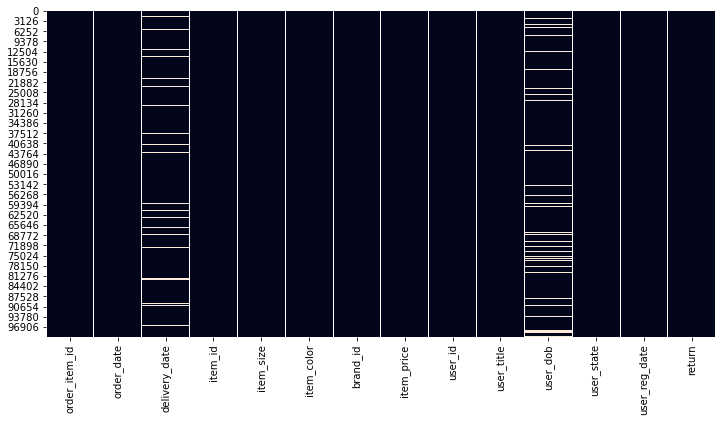

In [18]:
sns.heatmap(df.isnull(), cbar=False) # plot heatmap to see where missing values concentrate

<AxesSubplot:>

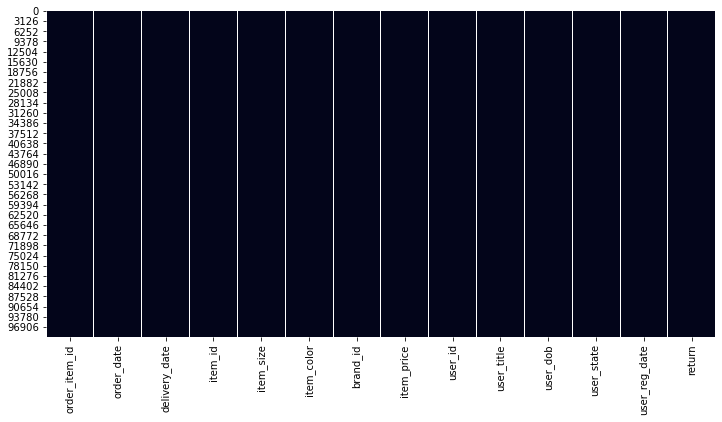

In [19]:
#Known Dataset

user_dob_mode_train = df['user_dob'].mode()[0] #check  if mode exists, and save it in  user_dob_mode_train
delivery_date_mode_train = df['delivery_date'].mode()[0] #same thing as in line before
df=df.fillna({'user_dob':user_dob_mode_train,'delivery_date':delivery_date_mode_train})
#missing elements of user_dob are replaced with the mode stored in user_dob_mode_train; the same is done for delivery_date

sns.heatmap(df.isnull(), cbar=False)

<AxesSubplot:>

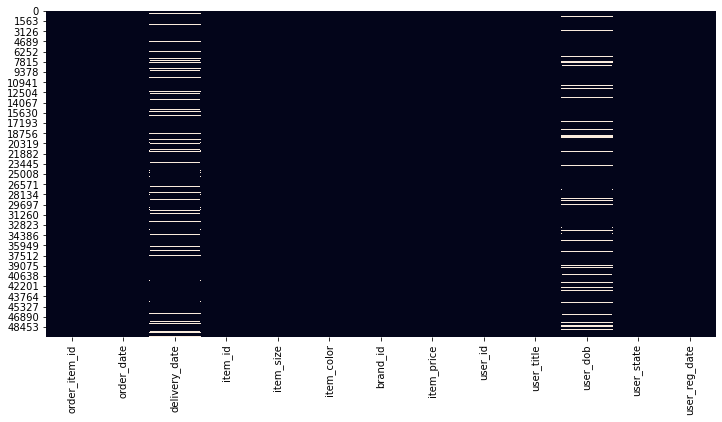

In [20]:
sns.heatmap(df_t.isnull(), cbar=False)

<AxesSubplot:>

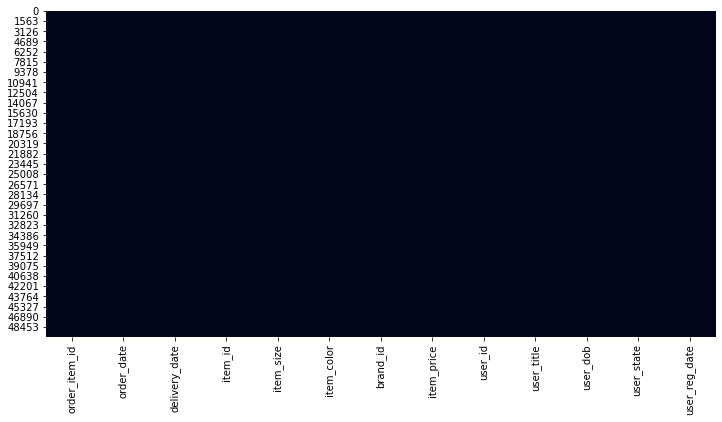

In [21]:
# Unknown dataset

user_dob_mode_test = df_t['user_dob'].mode()[0]
delivery_date_mode_test = df_t['delivery_date'].mode()[0]
df_t=df_t.fillna({'user_dob':user_dob_mode_test,'delivery_date':delivery_date_mode_test})

#plot heatmap 
sns.heatmap(df_t.isnull(), cbar=False)

## Feature Transformation

### Generate variables from date type variables

In order for the model to make predictions using datetime variables, some feature engeeniring should be applied to extrapolate more useful numeric features ( day, month, year, day of the week, etc ).

A for loop is used to obtain from both **user_dob** and **order_date** the following features:
- the week day: saved as a category

- the day of the month: pandas `.cut()` functionality is used to create 4 bins, each one corresponding to a range of days within a month. For example, [1-8] , [9-16], [17-23],[24-31]. The idea is that the exact day of birth, or order date may actually be irrelevant. To have a range of days can be more useful. 

- the month: saved as a category

- the year: saved as a numeric variable because between years there is a different order of magnitude. (example: 2021>2020 ) 

In [22]:
# Known dataset

for c in ['user_dob', 'order_date']: 
    df[c + '_wday'] = df[c].dt.weekday.astype('category') #day of the week
    df[c + '_day'] = pd.cut(df[c].dt.day, 4) #day. cut() is used for binning in 4 categories
    df[c + '_month'] = df[c].dt.month.astype('category') #month
    df[c + '_year'] = df[c].dt.year.astype('int64') #year
df = df.drop(columns=['user_dob', 'user_reg_date','order_date_year', 'order_date_month']) 

In [23]:
# Unknown dataset

for c in ['user_dob', 'order_date']:
    df_t[c + '_wday'] = df_t[c].dt.weekday.astype('category')
    df_t[c + '_day'] = pd.cut(df_t[c].dt.day, 4)
    df_t[c + '_month'] = df_t[c].dt.month.astype('category')
    df_t[c + '_year'] = df_t[c].dt.year.astype('int64')
df_t = df_t.drop(columns=['user_dob', 'user_reg_date','order_date_year', 'order_date_month']) 

### Outliers handling 

An outlier is a value that significantly differs from the rest of the data available; it can thus be marked as abnormal.  Regardless of the reasons, it can have adverse effects on the model prediction. Regression models are more sensitive to outliers than ensemble models like RandomForest. As a general rule, it is common practice to identify them and decide a plan of action.

The technique implemented in this notebook is called **clipping**: Outlier values are replaced with the extreme values at the lower-upper boundaries of the considered numeric column. 

Before clipping, it is first of all necessary to define the extreme boundaries of a numeric variable. Here, the **Tukey Fences Interquartile range (IQR)** is implemented. Values above and below such boundaries will be cast as outliers; now, the clipping technique will replace these observations with the extreme values at the boundaries.

A function that simulates the IQR approach is used to define the boundaries; a for loop is used to show a boxplot of the considered numeric variable, find the boundaries, and replace the outliers with clipping. 

The above approach is applied only to the numeric variable **user_dob_year** because for other variables it reduced their predictive power. Item_price and time_delivery perform better without using this technique. 


In [24]:
numeric_columns=df[['user_dob_year']]

In [25]:
def find_boundaries (df, variable, factor=1.5): #factor value set to default
    
    IQR= df[variable].quantile(0.75)-df[variable].quantile(0.25)
    
    lower_boundary= df[variable].quantile(0.25)-(IQR*factor) #find lower bound
    upper_boundary= df[variable].quantile(0.75)+(IQR*factor) #find higher bound
    
    return upper_boundary, lower_boundary

The boxplot displays several outliers, but a consideration should be done.  **user_dob** represents the year of birth of the customer. The maximum value found using the `.describe()` functionality is 2011. It is a real value related to a customer and would not be a right approach to substitute it. In essence, the values above the upper_boundary should not be replaced, and should rather be left as they are. On the contrary, the values showed by the boxplot that are below 1940 should be cast as outliers and replaced. Customers born before 1940 would have a very high age. 

user_dob_year before clipping


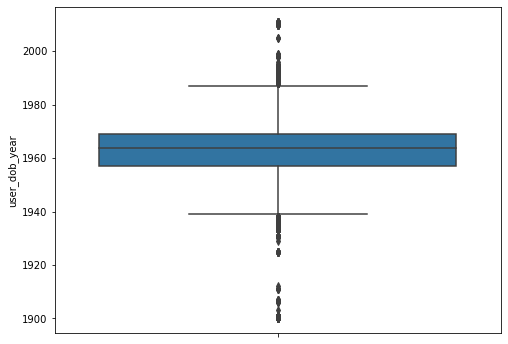

In [26]:
for c in ['user_dob_year']:
    print(c , 'before clipping')
    plt.figure(figsize=(8,6))
    sns.boxplot(y=df[c]) #it first plots a boxplot
    upper, lower = find_boundaries(df, c)#find higher bound
    df[c]= df[c].clip(lower) #it then clips the outliers with the corresponding values, only at the lower boundary 

user_dob_year outlier representation after clipping


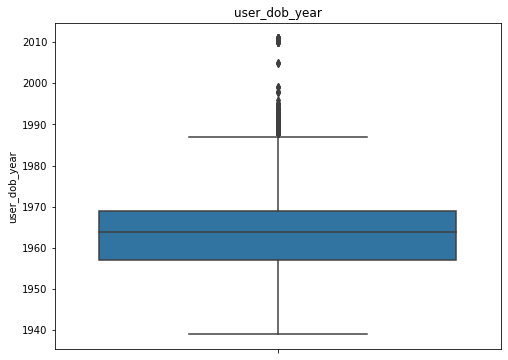

In [27]:
for c in ['user_dob_year']:
    print(c,'outlier representation after clipping')
    plt.figure(figsize=(8,6))
    sns.boxplot(y=df[c])
    plt.title(c)
    
#as mentioned, here only values below lower boundary are clipped. 

### Time to delivery 

This variable is obtained as the difference between order_date and delivery_date. The reason for its extraction is that the time of delivery of the product may influence whether the customer will return the product. 

In [28]:
#Known Dataset

#difference between date when order is made and date when order arrived is time_delivery
df['time_delivery'] = df['delivery_date'] - df['order_date']
df['time_delivery'] = df['time_delivery'] / pd.Timedelta(days=1)

#to eliminate anomalyis we set the mean of positive values and substitute negative values with it 
mean_deltime_positive = df['time_delivery'][df['time_delivery'] > 0].mean()
df['time_delivery'] = df['time_delivery'].where(df['time_delivery'] >= 0, other=mean_deltime_positive)

#original datetime columns are then removed 
df = df.drop(columns=['order_date', 'delivery_date'])

In [29]:
#Unknown Dataset

#difference between date when order is made and date when order arrived is time_delivery
df_t['time_delivery'] = df_t['delivery_date'] - df_t['order_date']
df_t['time_delivery'] = df_t['time_delivery'] / pd.Timedelta(days=1)

#to eliminate anomalyis we set the mean of positive values (line21) and substitute negative values with it 
mean_deltime_positive_t = df_t['time_delivery'][df_t['time_delivery'] > 0].mean()
df_t['time_delivery'] = df_t['time_delivery'].where(df_t['time_delivery'] >= 0, other=mean_deltime_positive_t)

#original datetime columns are then removed 
df_t = df_t.drop(columns=['order_date', 'delivery_date'])

### item_size transformation

This is a complex variable. 
1) Cardinality is high; there are too many categories.

2) Values are not expressed consistently/uniformly because different units of measurement are used. The problem arises when, for example, a value that corresponds to 'L' and a numerical value like '46' are not considered equal; the model distinguishes them although they are the same.

3) It is hard to make it homogenous. The item's size is measured based on the gender of the buyer and also on the item that is being purchased. For example, the t-shirt measurement for a man is different from the t-shirt measurement of a woman. Moreover, the shoe unit of measurement is, for example, different from the t-shirt measurement. Unfortunately, the dataset does not contain information about the type of item sold, which means it is not easy to convert the variable correctly. 

Nevertheless, an attempt to convert the variable has been made.
The information related to the user_title ( it can partially tell the gender ) and the item_size have been converted into a Pandas DataFrame, then exported in an Excel worksheet to check and transform the variable manually. I used a standard European woman size to convert the variable, figuring out for each case the best-sized converter to apply. 

 

source of size measurement converter: [size conversion source](https://www.blitzresults.com/it/taglie-europee/)

In [30]:
#dictionary of sizes to make the variable uniform 

item_size = {'xxxl':'XXXL','xxl':'XXL','xs':'XS','xl':'XL','unsized':'unsized','s':'S','m':'M',
            'l':'L','4034':'Other','4032':'Other','3834':'Other','3832':'Other','3634':'Other','3632':'Other',
            '3432':'Other','3332':'Other','3132':'Other','176':'Other','164':'Other','152':'Other','140':'Other',
            '128':'Other','116':'Other','105':'Other','104':'Other','100':'Other','90':'Other','84':'Other','80':'Other',
            '58':'XXL','56':'XXL','54':'XXL','52':'XXL','50':'XL','49':'XL','48':'XL','47':'L','46':'L','46+':'L','45':'L','45+':'L','44':'L','44+':'L',
            '43':'M','43+':'M','42':'M','42+':'M','41':'M','41+':'M','40':'M','40+':'M','39':'S','38':'S','39+':'S','38+':'S','37':'S','37+':'S','36':'S','36+':'S','35':'XS','34':'XS',
            '33':'XS','32':'XS','31':'XS','30':'XS','29':'XXS','28':'XXS','27':'XXS','26':'XXS','25':'XXS','24':'XXS',
            '23':'Other','22':'Other','21':'Other','20':'Other','19':'Other','18':'Other','14':'Other','13':'Other','12':'12','12+':'12+',
            '11':'11','11+':'11+','10':'10','10+':'10+','9':'9','9+':'9+','8':'8','8+':'8+','7':'7','7+':'7+','6':'6','6+':'6+','5':'5','5+':'5+','4':'4','4+':'4+','3':'3','3+':'3+',
            '2':'2','2+':'2+','1':'1', 'L':'L','XL':'XL','M':'M','XXL':'XXL','S':'S','XXXL':'XXXL','XS':'XS','4232':'Other','95':'Other','110':'110','122':'122'}

In [31]:
df['item_size_de']=df['item_size'].map(item_size.get) #.map() is used to change the values in the variable with item_size dictionary
df['item_size_de'] = df['item_size_de'].astype('category') #variable converted into category
df.drop('item_size',axis=1,inplace=True) #original variable is dropped

In [32]:
df_t['item_size_de']=df_t['item_size'].map(item_size.get)
df_t['item_size_de'] = df_t['item_size_de'].astype('category')
df_t.drop('item_size',axis=1,inplace=True)

### item_color transformation

Each color is composed of three basic colors: Green, Blue, Red. Almond, for example, is the result of a specific combination of them.  Here, three new columns are derived from item_color: item_color_red ; item_color_green; item_color_blue. Each new column is composed of the % portion of the basic color for a given color.

I used lambda functions and matplotlib color functionalities. Here is explained how:

`lambda`is used to create the new variables (**item_color_red,item_color_green,item_color_blue**). Every x or element of the new variables will be obtained by  first identifying the color with the function `is_color_like()`, then converting it into rgb numbers (perchentages of red, green and blue )using `to_rgb()`. Rgb are a set of three numbers, in our case given in %; the first % is the red color(index=0), the second one is the green color, the third is the blue color (index=2). Therefore in the item_color_red variable flows the first rgb number(index=0); in item_color_green the second rgb number (index=1); in item_color_blue the third rgb number (index=2). Whenever a color is not recognized by the function `is_color_like`, the lambda function takes the value from the dictionary created **color_name_rgb**

 

`from matplotlib.colors import to_rgb, is_color_like`

In [33]:
#Colors Dictionary 
color_name_rgb = {'almond': [ 0.937 , 0.871 , 0.804 ], '?': [0, 0, 0], 'amethyst': [0.6, 0.4, 0.8], 'ancient':[0,0,0], 'anthracite':[ 0.161, 0.192, 0.200 ],'antique pink':[ 0.788,0.475,0.482 ],
                 'apricot':[ 0.984, 0.808, 0.694 ],'ash':[ 0.745, 0.729, 0.655 ], 'aubergine':[ 0.216, 0.145, 0.157 ],'aviator':[ 0.165 , 0.188 , 0.341 ],
                 'avocado': [ 0.337 , 0.510 , 0.012 ],'baltic blue':[ 0 , 0.43 , 0.68 ],'basalt':[ 0.341 , 0.365 , 0.369 ],'berry':[ 0.553 ,0.306 , 0.522 ],'blau':[ 0 , 0.118 , 0.247 ],
                 'bordeaux':[0.298, 0, 0.075],'brwon':[0.588, 0.294, 0 ],'caramel':[1 , 0.835 , 0.604],'champagner':[0.98,0.839,0.647],
             'cobalt blue':[0,0.314,0.710],'cognac':[0.596,0.294,0.263],'copper coin':[0.675,0.404,0.239],'creme':[1,0.992,0.816],'curled':[0,0,0],
                 'currant purple': [0.502,0,0.502], 'curry':[0.616,0.569,0.004],'dark denim':[0.208,0.282,0.369],'dark garnet':[0.471,0.110,0.180],'dark grey':[0.663,0.663,0.663],
                 'dark navy':[0.008,0.027,0.365],'dark oliv':[0.333,0.420,0.184],'denim':[0.082,0.376,0.741],'ebony':[0.157,0.173,0.204], 'ecru':[0.761,0.698,0.502],
                 'floral':[1,0.980,0.941], 'habana':[ 0.231,0.169,0.235 ],'hibiscus':[ 0.702,0.212,0.329 ],'jade':[0,0.659,0,420],'kanel':[0.808,0.380,0.016], 'mahagoni':[0.753,0.251,0],'mango':[ 0.808 , 0.380, 0.016 ],
                 'mint':[0.596,1,0.596],'mocca':[ 0.435,0.216,0.176 ], 'nature':[ 0.349,0.486,0.169 ],'ocher':[ 0.800,0.467,0.133 ],'opal':[ 0.659,0.765,0.737 ],'pallid':[ 0.953,0.875,0.859 ],'petrol':[ 0,0.373,0.416 ],
                 'stained':[ 0.325,0.412,0.506 ], 'striped':[0,0,0],'terracotta':[ 0.886,0.447,0.357 ]}



In [34]:
# Known Dataset

#Lambda function to create new variables
df['item_color_red'] = df['item_color'].apply(lambda x: to_rgb(x)[0] if is_color_like(x) else color_name_rgb[x][0]) 
df['item_color_green'] = df['item_color'].apply(lambda x: to_rgb(x)[1] if is_color_like(x) else color_name_rgb[x][1])
df['item_color_blue'] = df['item_color'].apply(lambda x: to_rgb(x)[2] if is_color_like(x) else color_name_rgb[x][2])

#drop old color variable 
df.drop('item_color',axis=1,inplace=True)

In [35]:
# Known Dataset

#Lambda function to create new variables
df_t['item_color_red'] = df_t['item_color'].apply(lambda x: to_rgb(x)[0] if is_color_like(x) else color_name_rgb[x][0]) 
df_t['item_color_green'] = df_t['item_color'].apply(lambda x: to_rgb(x)[1] if is_color_like(x) else color_name_rgb[x][1])
df_t['item_color_blue'] = df_t['item_color'].apply(lambda x: to_rgb(x)[2] if is_color_like(x) else color_name_rgb[x][2])

#drop old color variable 
df_t.drop('item_color',axis=1,inplace=True)

### user_state transformation

This variable was also simplified to reduce cardinality. 

Cardinality here is reduced by filtering the states/locations of the original variables through a dictionary of three german regions: North Germany, South Germany, and Central Germany. 



In [36]:
Location={'North_Germany':['Lower Saxony','Schleswig-Holstein','Hamburg','Brandenburg','Mecklenburg-Western Pomerania','Bremen','North Rhine-Westphalia','Berlin','Saxony'],
         'South_Germany': ['Bavaria','Baden-Wuerttemberg','Saarland','Rhineland-Palatinate','Saxony'],
         'Central_Germany':['Hesse','Thuringia','Saxony-Anhalt']}

In [37]:
Location1={zone: k for k, v in Location.items() for zone in v}

In [38]:
#Known Dataset

df['user_from']=df['user_state'].map(Location1.get) #same process as in item_size transformation
df['user_from'] = df['user_from'].astype('category')
df.drop('user_state',axis=1,inplace=True)

In [39]:
#Unknown Dataset

df_t['user_from']=df_t['user_state'].map(Location1.get)
df_t['user_from'] = df_t['user_from'].astype('category')
df_t.drop('user_state',axis=1,inplace=True)

# Explanatory Data Analysis Part 2

### Distribution of numeric variables 

**item_price** has a lognormal distribution, and so does **time_delivery**. The item_color derived variables have awkward distributions, which is explained by the fact that they are derived from a categorical variable. 

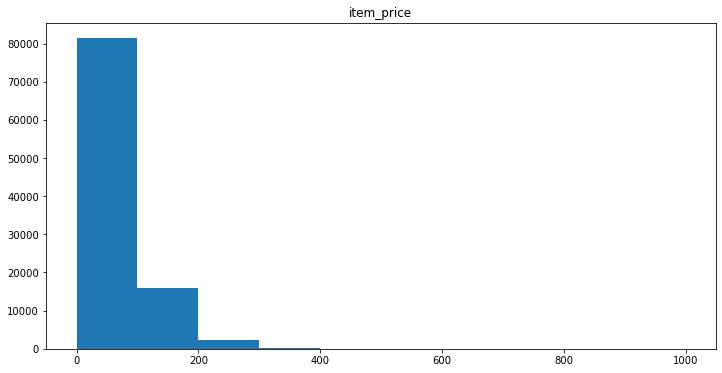

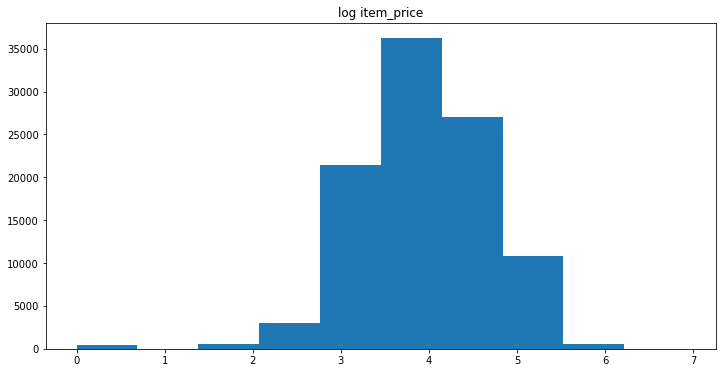

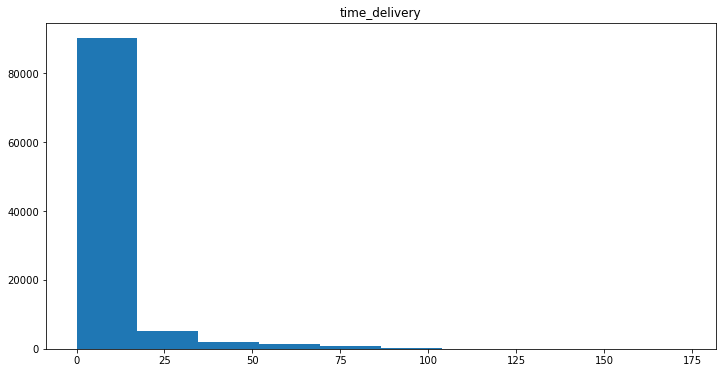

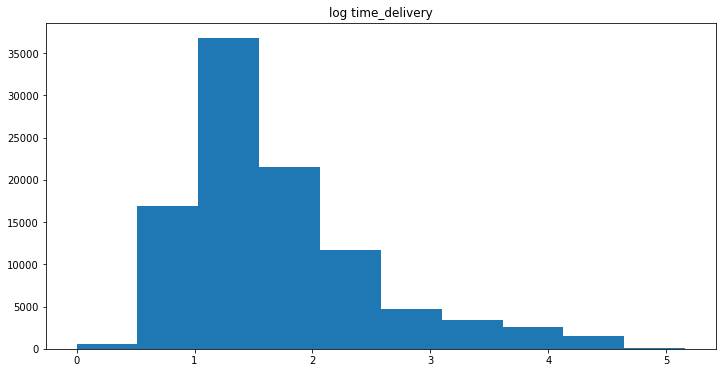

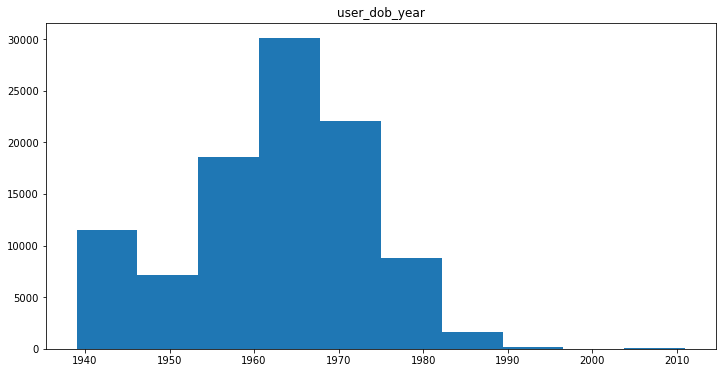

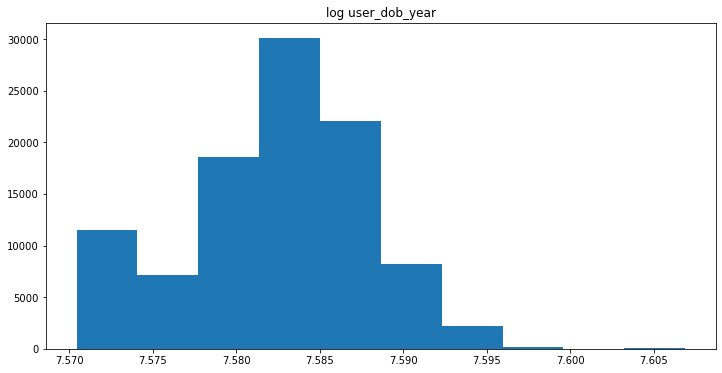

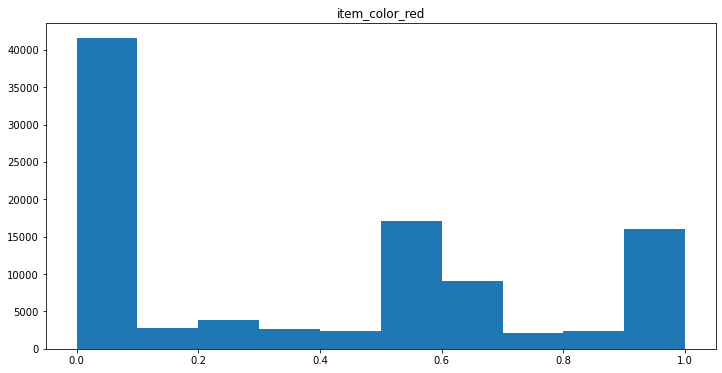

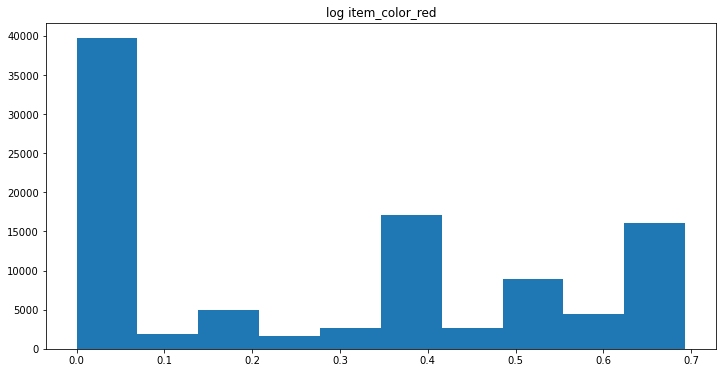

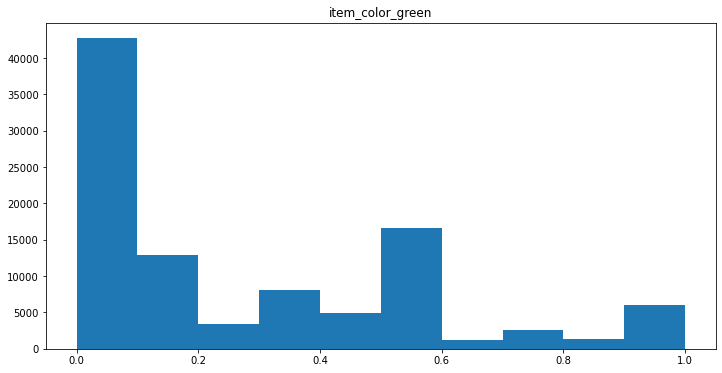

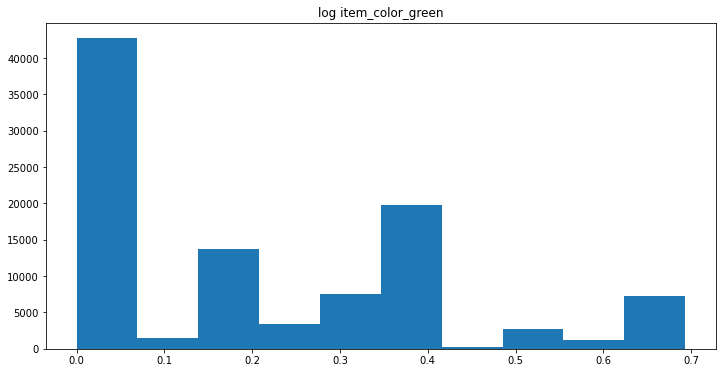

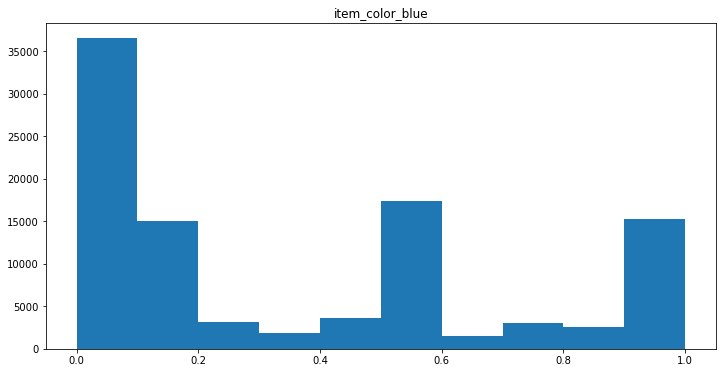

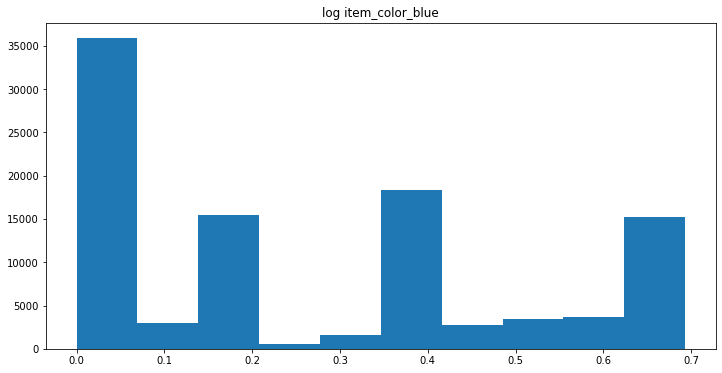

In [40]:
for f in ['item_price', 'time_delivery', 'user_dob_year', 'item_color_red', 'item_color_green', 'item_color_blue']:
    plt.title(f)
    plt.hist(df[f])
    plt.show()
    plt.title('log ' + f)
    plt.hist(np.log1p(df[f])) #here is applied the log to show the normalized variables
    plt.show()

### Correlation between Categoric variables

Multicollinearity is the problem of having independent variables highly correlated to one another. One of the variables can be used to predict the other, and redundant information is created. This can harm the model, especially for linear and logistic regressions.

In this section, the focus will be on checking if there is multicollinearity. Because the Dataset has both numerical and categorical features,  Cramer V coefficient is used to investigate categorical variables and Pearson correlation for numeric variables instead. 

- Source of information: [towardatascience](https://towardsdatascience.com/the-search-for-categorical-correlation-a1cf7f1888c9)

- In order to calculate Cramer V correlation I have installed the package [association- metrics](https://pypi.org/project/association-metrics/)

    `pip install association-metrics`
    
    `import association_metrics as am`
    
### Cramer V consideration

**item_size** and **brand_id** are the only categoric variables that have some correlation between each other ( 0.31 ), although it is not high enough to justify removing one of the two, at least at this point. **brand_id** also shows the highest correlation, among the variables included in the table, with the target variable **return**. At the beginning of the notebook, by crosschecking the link between brand_id and the target, it emerged that some brands indeed were associated with (non)returns. These considerations support the fact that **brand_id** could be helpful for prediction

In [41]:
categoric_columns=df.select_dtypes('category').drop(['user_dob_wday','user_dob_month','order_date_day','item_id','user_id'],axis=1)


In [42]:
# Initialize a CRAMERES V object using our pandas data frame df
cramersv = am.CramersV(categoric_columns) 

In [43]:
# will return a pairwise matrix filled with Cramer's V, where columns and index are the categorical variables of the passed pandas.DataFrame
cramersv_matrix=cramersv.fit()

<AxesSubplot:>

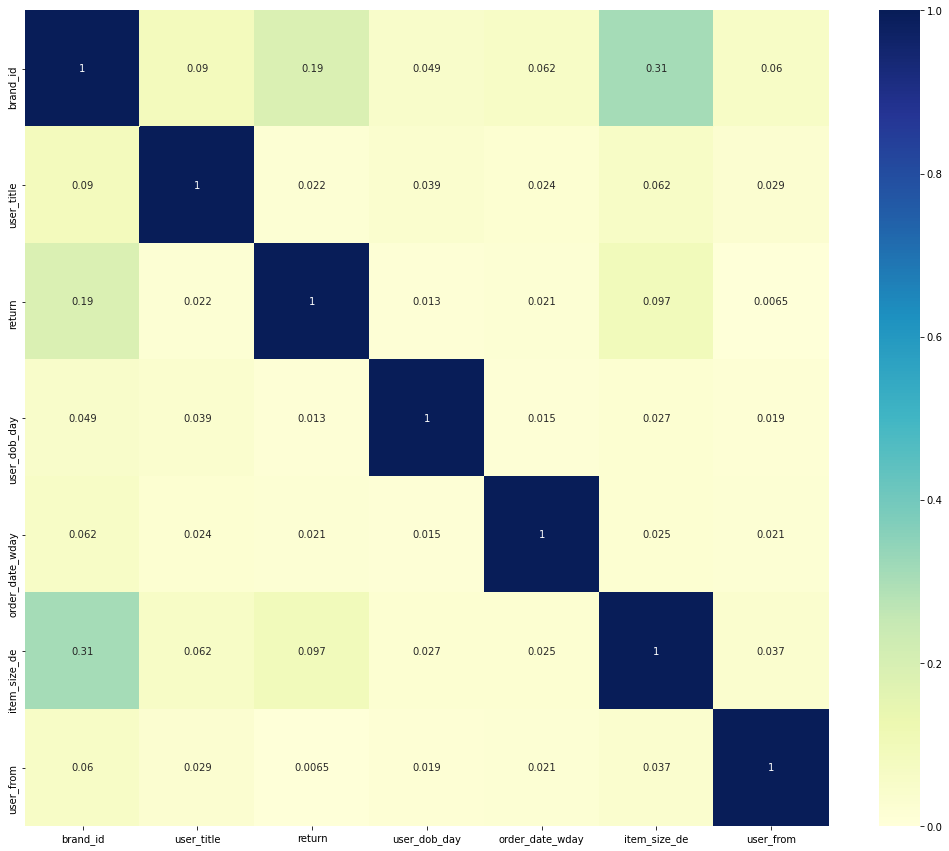

In [44]:
fig, ax = plt.subplots(figsize=(18,15))
sns.heatmap(cramersv_matrix, annot=True, cmap="YlGnBu" , ax=ax, vmin=0, vmax=1)

### Correlation between Numeric columns

The **Pearson correlation coefficient** measures the linear association between two variables, with values ranging from +1 to -1. A value of 1 means that there is complete positive correlation, and viceversa. Applying the `corr()` on df, and plotting the result using `sns.heatmap` allows me to  visually inspect the correlations of numeric variables in my data frame. 

- **item_price** has a Pearson coefficient of 0.27 with order_item_id. Order_item_id is not a predictive variable and will be removed before implementing the models. A more important indication is that item_price has a 0.14 correlation with the target variable. More than any other variable; it can be a useful variable for our model.

- the features derived from **item_color** have higher correlations between each other. However, it is still a correlation below <0.5. By trying to remove one of them, the model did not improve, so all three of them are kept. 


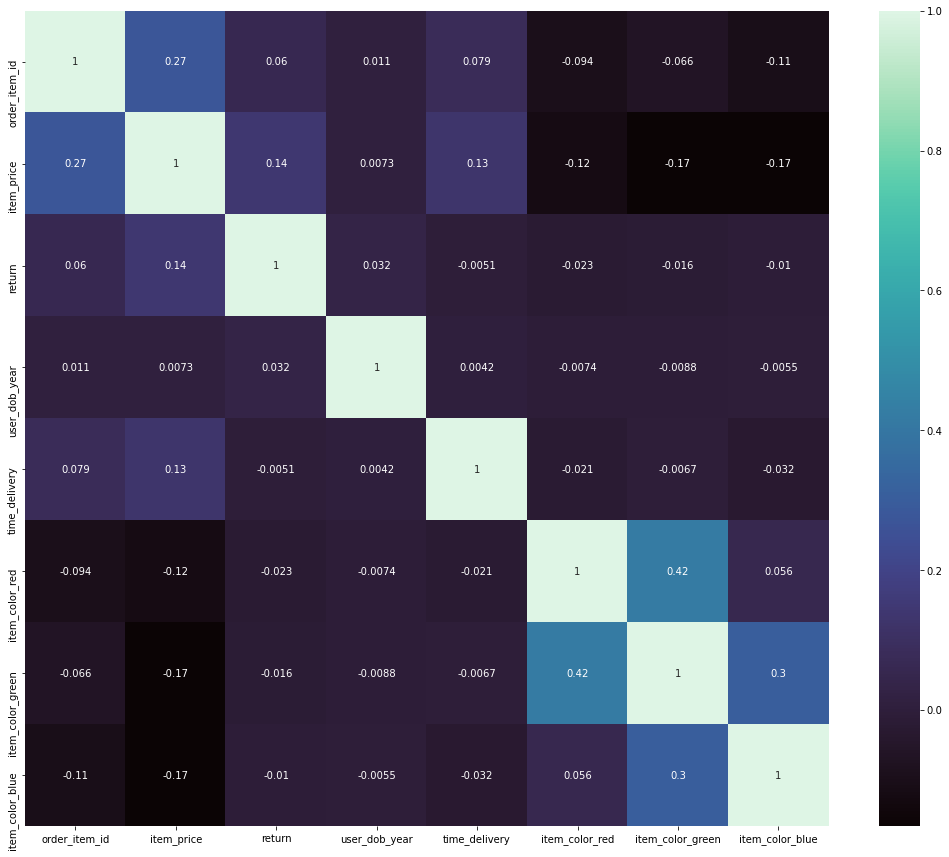

In [45]:
#to show the  correlation of return on heatmap, the variable has to be stored as a numeric variable
df['return']=df['return'].astype('int64')

fig, ax = plt.subplots(figsize=(18, 15))

pearson_corr= df.corr()

sns.heatmap(pearson_corr,
            xticklabels=pearson_corr.columns.values,
            yticklabels=pearson_corr.columns.values,
            annot=True,
            cmap="mako");

#change return back to boolean
df['return']=df['return'].astype('bool')

# DATA PREPARATION Part.2

## Data Transformation

### Normalization with Log

Normalization is the process of converting an actual range of values into a standard range of values such as [0,1]. Normalization is usually done because it helps increase the speed of learning, and also ensures that numeric values are approxiamtely in the same range. Some algorithms like Logistic regression can be sensitive to such issues with the data, and normalization can help obtain better results. In EDA part.2 distributions are only investigated. Here, variables are normalized


**Item_price** and **Time_delivery** are not normally distributed; log is applied to make them approximately normal . **User_dob_year** on the other hand is by its nature normally distributed and does not need adjustments with box-cox or other procedures. 


source: [machinelearning mastery](https://machinelearningmastery.com/rescaling-data-for-machine-learning-in-python-with-scikit-learn/)

In [46]:
def vars_transform(df):
    df['log_item_price'] = np.log1p(df['item_price'])
    df['log_time_delivery'] = np.log1p(df['time_delivery'])
    df['user_dob_year'] = df['user_dob_year'].clip(1940)
    #del df['item_price']  # bisogna tenere item_price non scalato per la treshold nella sezione di model selection
    del df['time_delivery']

In [47]:
vars_transform(df)
vars_transform(df_t) 

In [48]:
def diagnostic_plots(df,variable):
    
    plt.figure(figsize=(15,6))
    df[variable].hist(bins=10)
    plt.show()

**item_price** now has a normal distribution

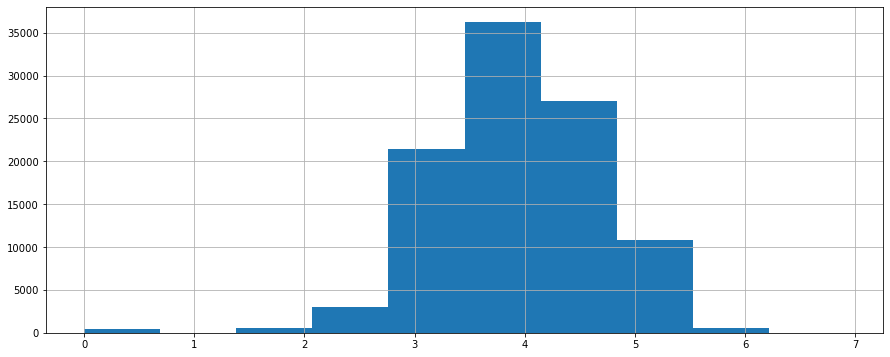

In [49]:
diagnostic_plots(df,'log_item_price')

**time_delivery** is quiet normal as well 

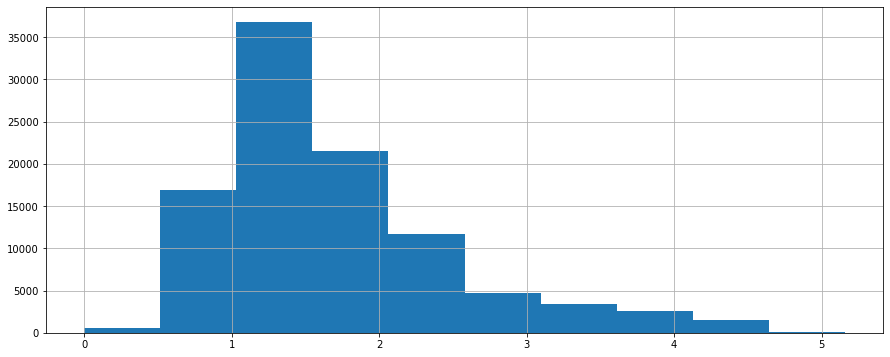

In [50]:
diagnostic_plots(df,'log_time_delivery')

### Brand_id 

From EDA analysis, this variable can be helpful for the model, but it has one crucial problem: it has a very high cardinality. Many variables can only be found on the Known dataset, while others only on the Unknown set. A model trained on unique categories can raise issues; therefore, some feature engineering work is necessary. By looking at its interaction with the target, only some Brands look relevant for prediction purposes. 

**Here is the idea**
A vector of booleans is created for every brand_id, found in both known and unknown sets, where the probability p of an event to be returned is higher than 70% or lower than 30%. The vectors will show the *True* label whenever the specific brand_id appears in the model; otherwise, the label *False* will appear. This should allow the model only to care when the specific brand_id appears and also does not create issues whenever there are discrepancies in the data. 

In [51]:
brand_id_return = pd.crosstab(df['brand_id'], df['return'], normalize='index')
brand_id_return

return,False,True
brand_id,,
1,0.510560,0.489440
2,0.580336,0.419664
3,0.633418,0.366582
4,0.506237,0.493763
5,0.608454,0.391546
...,...,...
134,1.000000,0.000000
135,1.000000,0.000000
136,0.857143,0.142857


In [52]:
useful_brands = [] #here will flow all useful brands that appear in both datasets
train_brands = set(df['brand_id'].unique()) #selects unique brands
test_brands = set(df_t['brand_id'].unique())
for b in brand_id_return.index:
    p = brand_id_return.loc[b, 1]
    if p > 0.7 or p < 0.3:#allows to make a selection of useful brands based on their interaction with the target
        if b in train_brands and b in test_brands: #if the brand is present in both datasets will be appended in useful_brands
            useful_brands.append(b)

In [53]:
#here boolean vectors are created for each useful brand_id

for b in useful_brands:
    df['brand_' + str(b)] = df['brand_id'] == b
    df_t['brand_' + str(b)] = df_t['brand_id'] == b

In [54]:
#original variable id dropped from datasets

df = df.drop(columns='brand_id')
df_t = df_t.drop(columns='brand_id')

### Feature Selection

The feature selection phase in this notebook was undertaken iteratively. For every iteration different combinations of features were tried in order to find the best model overall performance, both in terms of **total costs** and of **ROC AUC score**. In general, the Logistic regression was more sensitive to changes, while ensemble methods like RandomeForest, were not affected much. Because in this notebook the focus is on ensemble models, the majority of features is actually kept. A wrapper method was also tried out, but did not deliver satisfying results, therefore it was discarded.

Here below are the feature that are dropped because of their low predictive power.

- order_item_id

- item_id

- user_id


In [55]:
#by dropping it AUC increased of 5%

#known
df.drop('order_item_id',inplace=True,axis=1)

#unknown
df_t.drop('order_item_id',inplace=True,axis=1)

In [56]:
#by dropping it AUC increased of 1% 

#known
df.drop('item_id',inplace=True,axis=1)

#unknown
df_t.drop('item_id',inplace=True,axis=1)

In [57]:
#by dropping it AUC increased of 1% 

#known
df.drop('user_id',inplace=True,axis=1)

#unknown
df_t.drop('user_id',inplace=True,axis=1)

# Last preparations before applying models on Train set

### X&y  

In [58]:
#let's define X&y

X=df.drop(['return'],axis=1)
y=df['return']

### One hot encoding

One Hot encoding is a procedure used to encode categorical variables. It is often a required step because many machine learning algorithms can't operate directly on labeled data. The first step is to create a variable, cat_columns, comprising the categoric columns to dummy encode. Afterwise, the pandas' functionality `get_dummies`  is implemented: N binary variables are created for every category of any categoric feature included in cat_columns.

In [59]:
cat_columns = X.select_dtypes('category').columns.tolist()
cat_columns_t = df_t.select_dtypes('category').columns.tolist()

In [60]:
#Let's get dummy variables from categoric columns
X = pd.get_dummies(X, columns=cat_columns)

#Let's get dummy variables from categoric columns
df_t = pd.get_dummies(df_t, columns=cat_columns_t)

The following code implements a nested loop to find the columns that are only present in the known or the unknown set; the highlighted columns are saved in the *to_drop* variable and afterwise dropped. This is a necessary step as some problems may emerge:

- if a column is only present on the train set, the model would train on a variable that is only found during validation. Eventually, the model could perform differently on the validation daset than it would do in the unknown datasets.
- The opposite is also true; If a model already trained and validated is applied to make predictions on new data, where there are features that it has never seen before, how can it make predictions?

In [61]:
to_drop = []
to_drop_test = []
for c in df_t.columns.tolist():
    if c not in X.columns.tolist():
        to_drop_test.append(c)
for c in X.columns.tolist():
    if c not in df_t.columns.tolist():
        to_drop.append(c)
        print(c)

item_size_de_2+


In [62]:
X = X.drop(columns=to_drop)
df_t = df_t.drop(columns=to_drop_test)

In [63]:
len(X.columns), len(df_t.columns)

(114, 114)

# Train-Test split

Here a train-test split approach is used. The models are trained on the train set and are then tested on a smaller set to assess their performances; see if they generalize well and can be applied to the final known set, the Unknown data.

The part of Data preparation was necessary to obtain the final set of labeled data, df. From df, X and y are extrapolated.  Sklearn functionality is then used to split X and y into X_train, X_test, and y_train,y_test. The model is trained on the train set and eventually applied to the test to see how well it predicts the 0,1 classes.

In [64]:
# Separate into train and test sets

item_price = X['item_price'] #it will be usefull later in the notebook
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3)


In [65]:
#it will be usefull later in the notebook

item_price_train = X_train['item_price']
item_price_test = X_test['item_price']
del X_train['item_price']
del X_test['item_price']

# MODEL TUNING & SELECTION 


**Model Selection**


This part of the notebook is dedicated to the implementation of the models. 

The model that overall performed best considering the total costs that its prediction generates, and the AUC/ROC score, is then chosen to make the final predictions on new data.

The following models are tested:

- Logistic Regression

- Decision Tree

- Random Forest

- XGBoosting

### Asymmetric error 


As in real life, the type of mistake made by the model can have different impacts, in terms of costs, on the business enterprise that takes decisions based on such results.
    
The function `competition_err` works as follows: 

1) step: **mask_error1** identifies the **TN** error and creates two boolean vectors that when the predicted y is equal to the true y gives back the **False** value; otherwise, it gives back **True**. In the opposite way works **mark_err_0**, which detects the **FP** error

2) step: afterwise, *error* is determined using the FN cost function. `𝑣`is the value of the purchased object, which is represented by **item_price**. Eventually, the same is done with the FP cost function. The total cost is obtained by summing the two errors. 

In [66]:
def competition_err(y_true, y_pred, item_price):
    mask_err_1 = (y_true == 1) & (y_pred == 0) # boolean vectors to identify number of FN errors
    mask_err_0 = (y_true == 0) & (y_pred == 1) # boolean vectors to identify number of FP error
    error = 0.5 * 5 *(3 + 0.1 * item_price[mask_err_1]) #error of FN cost function
    error = np.sum(error)
    error_0 = 0.5 * item_price[mask_err_0] #error of FP cost function
    error += np.sum(error_0)
    return error

### Definition of Treshold 

Now that a function to determine the costs for each error is defined, it is now time to determine a threshold for assigning the predicted class in terms of probability to the 0 or 1 classes. 

Here is defined a function called `find_best_threshold` that automatically calculates the threshold that minimizes costs. It is set the initial minimum cost *c_min=infinite* because the objective is to minimize costs, and the successive *total cost* of the loop will have to be inferior to be stored; and also the best threshold value *best_t=-1*. A for loop is used to select in `np.linespace(0.01,0.99, 500)` 500 values for the threshold ranging between 0.01 and 0.99 with the purpose to try them and choose the one that minimizes total costs. Afterwise, in **y_pred** are automatically stored the labels (0,1) obtained from classifing the *y_pre_prob (probabilistic predictions obtained by a model)*  using each of the 500 possible thresholds. Then, the `competition_error` function previously defined is called using the *y_pred* defined in the previous lines. 
The total cost obtained for a given threshold, if inferior to *c_min*, is stored in memory as the new *c_min* toghether with the threshold *best_t*. The process is interrupted after 500 trials, and returns back the best threshold found as well as its related minimized total cost

Also, `tqdm`  library, included in the conda package, is implemented; it uses progress bars to see how long it can take to process a line of code. I used it in the function below.

`import tqdm`


source: [towardsdatascience](https://towardsdatascience.com/progress-bars-in-python-4b44e8a4c482)

In [67]:
def find_best_threshold(y_true, y_pred_prob, item_price):
    c_min, best_t = float('inf'), -1 #set c_min and best_t
    for t in tqdm.tqdm(np.linspace(0.01, 0.99, 500)): #try 500 different thresholds between 0.01 and 0.99
        y_pred = y_pred_prob >= t #discretize probability predictions in (0,1) labels
        y_pred = y_pred.astype('float')
        c = competition_err(y_true, y_pred, item_price) #apply competition_error to find total cost linked to given threshold
        if c < c_min: #if c<c_min then c is stored as the new c_min together with the best_t
            c_min = c
            best_t = t
    print('best threshold', best_t, 'with cost', c_min) #at the end it returns the best threshold and total costs which are now minimized
    return best_t

### Logistic Regression

 

In [68]:
weights = 'balanced' #it is useful for cost-sensitive learning to assign different weights to the label
#but in this case it does not change much

In [69]:
#Define Logit
logistic = LogisticRegression(C=0.911, max_iter=1_000, class_weight= 'balanced')

# Fit model to data
logistic.fit(X_train, y_train)

#Make prediction
y_prob_test = logistic.predict_proba(X_test)[:, 1]

#Define treshold 
t_logit = find_best_threshold(y_test.values, y_prob_test, item_price_test)

#Make prediction based on Treshold
y_pred_test = (y_prob_test > t_logit).astype('int')


100%|██████████| 500/500 [00:00<00:00, 533.87it/s]

best threshold 0.711122244488978 with cost 347984.74500000005


### Decision Tree


Together with the Decision Tree, an interesting library is used to show the Decision tree path to make decisions. 

`!pip install dtreeviz`

In [70]:
#define decision tree
dt = tree.DecisionTreeClassifier(max_depth=5,criterion="entropy", min_samples_split=2) #keep tree at a low depth

#fit decision tree to data 
dtree = dt.fit(X_train, y_train)

#predict probabilities
y_prob_test1=dt.predict_proba(X_test)[:, 1]

#Define Treshold 
t_dt = find_best_threshold(y_test.values, y_prob_test1, item_price_test)

#predic classes using treshold
y_pred_test1 = (y_prob_test1 > t_dt).astype('int')

#total cost 
competition_err(y_test, y_pred_test1, item_price_test)

100%|██████████| 500/500 [00:00<00:00, 542.93it/s]

best threshold 0.608997995991984 with cost 341304.19250000006


341304.19250000006

**dtreeviz** is an interesting library that allows to show the path of the DecisionTree; more specifically you can see where the splits are made, the number of trees ect. More in general, it is an interesting way to visualize and extrapolate the rules used by the model to make predictions

In [71]:
viz = dtreeviz(dt, 
              X_train,
              y_train,
              target_name='return',
              feature_names=X_train.columns.tolist(), 
              class_names=["0", "1"],
              orientation='LR')

In [72]:
viz.view()

the **dtreeviz file** is uploaded toghether with the notebook for the submission

In [73]:
viz.save('decision_tree.svg')

### Random Forest

The third argument of the RandomForest trained below is `sample_weight=item_price ` (scaled with min-max scaling). The rationale for this is as follows: for this assignment, in the end what matters is the total cost derived from making the wrong predictions; because the total cost depends on `𝑣` (item_price), the model should give more importance to correctly predict  labels of items with the higher prices, and less relevance to lower-priced items. 

Another useful step for cost sensitive approaches is to use the `class_weight` hyperparameter. The idea is to give more importance to one class or the other. In this scenario, a balanced solution returned the lowest costs. A reason can be that the cost matrix errors FP and FN depend on item_price value. When the price of an item gets over a certain level, the FP cost is larger than FN, but the opposite is also true. Below a certain level the FN cost is higher than FP. If costs where constant, the weights could have been different.


In [74]:
#Cost sensitive weighing 

weights = 'balanced'

In [75]:
#define RF
rf = RandomForestClassifier(n_estimators=1500,
                            max_depth=20,
                            class_weight=weights,
                            n_jobs=2)

#fits the model  
rf=rf.fit(X_train, y_train, minmax_scale(item_price_train))

#predicts probabilities 
y_prob_train2 = rf.predict_proba(X_train)[:, 1]
y_prob_test2 = rf.predict_proba(X_test)[:, 1]

#finds best threshold 
t_rf = find_best_threshold(y_test.values, y_prob_test2, item_price_test)

#predict classes  using treshold
y_pred_test2 = (y_prob_test2 > t_rf).astype('int')
y_pred_train2 = (y_prob_train2 > t_rf).astype('int')

100%|██████████| 500/500 [00:00<00:00, 512.01it/s]

best threshold 0.6070340681362726 with cost 320161.49500000005


In [76]:
competition_err(y_train, y_pred_train2, item_price_train)

245225.7525

In [77]:
competition_err(y_test, y_pred_test2, item_price_test)

320161.49500000005

### Hyper parameters tuning for ensemble algorithms 

Hyperparameters are not optimized by the learning algorithm itself, but have to be set manually to find the best combinations. 

 
Two ways of doing this are **GridSearch** and **RandomSearch** methodologies. The first one operates by iteratively setting the hyperparameters of a pre-defined set of values and choosing the ones that lead to the best predictions (considering the performance metrics indicated like Auc). RandomSearch proceeds in a similar way but randomly tests the settings between pre-defined intervals of values of given hyperparameters. 

In this notebook, the configuration of hyperparameters is done with RandomSearchCV. 

### Random Forest hyperparameters tuning

Here are the main Hyperparameters to tune: 

- n_estimators: it represents the number of trees in the forest. The higher is this value and the bettere the model will perform. 

- max_depth: it represents the depth of each tree in the forest. A higher value means that a tree has more splits, and thereby captures more information  

- min_samples_split: it specifies the minimum number of  samples required to split an internal node 

- min_sample_leaf: minimum number of samples required to be at a leaf node 

**source:** 
- [medium article on data science](https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d)
- [towardsdatascience](https://towardsdatascience.com/gridsearchcv-or-randomsearchcv-5aa4acf5348c#:~:text=RandomSearchCV%20has%20the%20same%20purpose,parameters%20to%20improve%20your%20model.&text=The%20main%20difference%20between%20the,want%20to%20sample%20and%20test.)
- [towardsdatascience](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]

# Maximum number of levels in tree
max_depth = randint(low=5, high=50)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]

# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]

In [ ]:
tuned_parameters1 = {'n_estimators': n_estimators,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }


In [ ]:

# First create the base model to tune
rf_RS = RandomForestClassifier(random_state=888,class_weight='balanced')
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf_RS, param_distributions = tuned_parameters1, n_iter = 5, cv = 3, verbose=2, n_jobs = 1)
# Fit the random search model
#rf_random.fit(X_train, y_train)

In [ ]:
#print(rf_random.best_params_)
#print(rf_random.best_score_)

### XGBoost

The main hyperparameters to tune here are: 

- colsample_bytree: it corresponds to the fraction of features to use. 

Optimal value: **0.5339397871664028**

- n_estimators: it represents the number of trees like in Rf

Optimal value: **201**

- max_depth: like in random forest, it is the maximum depth allowed from the root of the tree to its last leaf. The higher this number is and the better will the model perform, but as it goes deeper, the nodes become more complex and specific and could cause the model to overfit

Optimal value: **37**

- learning_rate: it is the shrinkage you do at every step you are making. If the learning rate is deacreased, the number of iterations should be increased in proportion

Optimal value: **0.002756489320942917**


**source:**
- [cambrigde spark](https://blog.cambridgespark.com/hyperparameter-tuning-in-xgboost-4ff9100a3b2f)
- [kaggle](https://www.kaggle.com/c/santander-customer-satisfaction/discussion/20208#115472)

In [ ]:
xgb_param_grid = {
   'colsample_bytree': uniform(0.5, 0.48), 
   'n_estimators': randint(low=50, high=500),  
   'max_depth': randint(low=5, high=50),   
   'learning_rate': loguniform(a=10**-5, b=10**-1)
    }  


In [ ]:
random_xgb = RandomizedSearchCV(estimator=xgb.XGBClassifier(use_label_encoder=False),
                                param_distributions=xgb_param_grid, 
                                scoring='roc_auc', cv=3, verbose=0,n_iter=5)

In [ ]:
#random_xgb.fit(X_train.values, y_train.values.ravel().astype('int'))

In [ ]:
#print(random_xgb.best_params_)
#print(random_xgb.best_score_)

# MODEL EVALUATION

The Logistic Regression and DecisionTree did not perform well compared to the ensemble algorithms implemented. Therefore,in this section we will mainly focus on RandomForest and XGB

### Confusion Matrix

A confusion matrix is a table that summarizes how successful the classification model is at predicting examples belonging to various classes. One axis is the label representing the predictions of the model. The other axis represents the actual classes.

**TP:** The model predicts that the customer will return the product. A message is shown to the customer which as a consequence does not buy the item. In reality the customer would have returned the item

**FP:** The model predicts that the customer will return the product. A message is shown to the customer which as a consequence does not buy the item. In reality, it would have not returned the product. The cost corresponds to the lost opportunity of earning money. 

**TN:** the model predicts that the customer will keep the item, and in reality it keeps it.

**FN:**  The model predicts that the customer will keep the item, but in reality it returns it. The cost is given by the money lost by the merchatnt (it has to give it back), and also the shipping costs for return. 


**RandomForest**

In [ ]:
plot_confusion_matrix(rf, X_train, y_train)
plt.show()
plot_confusion_matrix(rf, X_test, y_test)
plt.show()

**XGBoosting**

In [ ]:
plot_confusion_matrix(xgb_classifier , X_train, y_train)
plt.show()
plot_confusion_matrix(xgb_classifier , X_test, y_test)
plt.show()

### Feature Importance

**RandomForest**

As can be seen from the graph below, the most important features are **time_delivery, item_price, user_dob_year, and the color variables created.**  

Logically, customers don't want to lose time dealing with the return process, so when the product is cheap, they prefer to let go of any discrepancies with the product; on the other hand, if the item is expensive, the customer is less likely to let problems with the product go, and may return the product. The model captures this effect and uses it to predict the class.

Time_delivery seems to be helpful in predicting the label. A logical explanation would be that the longer the time to deliver a purchased item, the worse it could be the customer's experience with the merchant e-commerce. This could mean that the customer is more likely to return a product. 

In [ ]:
X_var_labels = X.columns[1:X.shape[1]]
feat_importances_rf = pd.Series(rf.feature_importances_, index= X_var_labels)
feat_importances_rf.nlargest(20).plot(kind='barh')

**XGBoosting**

Differently from RandomForest, the most useful feature for XGB is **user_dob_year**, followed by **item_price** and **time_delivery** which confim themselves to be among the most useful. 

In [ ]:
plot_importance(xgb_classifier,max_num_features=10,) #problema con indexing

**source:** [towardsdatascience](https://towardsdatascience.com/running-random-forests-inspect-the-feature-importances-with-this-code-2b00dd72b92e)

### ROC Curve 

The ROC curve (Reciever operating characteristic) is commonly used to assess the performance of classification models, like this one. It uses a combination of the **true positive rate** also known as recall, and the **false positive rate** which represents the proportion of negative examples predicted incorrectly. The area under the ROC curve is also knwon as **AUC**: a classifier that has an AUC higher than 0.5 is better than a random classification, while if the AUC is lower than 0.5, the model makes worst prediction than a random classifier and perhaps something is wrong. In this notebook, the tested models are inserted on the same graph to see how well each one performs compared to the others. In this case RandomForest and XGBoost are the most performing, with an AUC that can be approximated to 70%

To plot a ROC Graph it is required to have the probability predictions of the models, and not the actual lables 0 or 1 

**source:** [machinelearning mastery](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/)

In [ ]:
#Logit
fpr_logit, tpr_logit, _ = metrics.roc_curve(y_test, y_prob_test) 
auc_logit = metrics.auc(fpr_logit, tpr_logit)

#DecisionTree
fpr_dt, tpr_dt, _ = metrics.roc_curve(y_test, y_prob_test1) 
auc_dt = metrics.auc(fpr_dt, tpr_dt)


#RandomForest
fpr_rf, tpr_rf, _ = metrics.roc_curve(y_test, y_prob_test2 ) 
auc_rf = metrics.auc(fpr_rf, tpr_rf)


#XGboosting
fpr_xgb, tpr_xgb, _ = metrics.roc_curve(y_test, y_prob_test3) 
auc_xgb = metrics.auc(fpr_xgb, tpr_xgb)

#Roc Curve
plt.plot(fpr_xgb,tpr_xgb, label="XGB=%0.4f" %auc_xgb , color='green')
plt.plot(fpr_rf, tpr_rf, label="RF= %0.4f" % auc_rf, color='blue')
plt.plot(fpr_dt, tpr_dt, label="DT=%0.4f"% auc_dt,color='pink')
plt.plot(fpr_logit, tpr_logit, label="Logit=%0.4f"% auc_logit, color='red')

# Random benchmark for axes
plt.plot([0, 1], [0, 1], "r--");  

# Plot configuration
plt.title('ROC Curve comparison of model used')
plt.ylabel("True Positive Rate")
plt.xlabel("False Positive Rate")
plt.legend(loc="lower right")
plt.show()

### Model Performance Assessment

Several models are built using the train set and tested on the validation set to see how well they perform on unseen data. If a model performs well on predicting the labels of the validation set, then the model should ,in theory, generalize well; it should make good predictions on new data. From the **Model Evaluation** phase the following helpfull insights have emerged. Let's do a recap:

`Random Forest`

**AUC score**:0.6966 

**Total Costs**: 321341.88250000007

**Cost-minimizing Threshold**: 0.5893587174348698


`XGBoost`

**AUC score**:0.7088

**Total Costs**: 310166.03750000003

**Cost-minimizing Threshold**: 0.5186573146292586


`Decision Tree`

**AUC score**: 0.6458

**Total Costs**: 345508.7300000001

**Cost-minimizing Threshold**: 0.5972144288577155


`Logistic Regression`


**AUC score**: 0.6016

**Total Costs**: 353056.23750000005

**Cost-minimizing Threshold**: 0.7405811623246493


### Final model choice
XGBoost seems to be the most performing model  among the ones considered. A good Data Scientist, based on the selection process implemented, would use it to process the *Unknown dataset*. However, since this started as a kaggle competition, there is another factor to take into account: on Kaggle, Random Forest performs slightly better in terms of AUC than XGBoost, and although the assignment is evaluated based on total costs, my hypotesis is that Random Forest would perform better also in terms of costs. Concluding, in a real life scenario, XGBoost would be the rational choice; on kaggle, I opt for Random Forest.  

# CONCLUSION

In [ ]:
X_final=X.drop('item_price',axis=1)

test=df_t.drop('item_price',axis=1)

### RandomForest finale

Eventually the final model is trained on X ( and not X_train because it would have less data to train on ). The hyperparameters are the same used previously. The probability predictions  are then converted  in (0,1) labels. 

In [ ]:
#define final rf
rf = RandomForestClassifier(n_estimators=1500,
                           max_depth=18,
                           n_jobs=2,
                           class_weight='balanced')

#fit model on X_final 
rf=rf.fit(scale(X_final.values),y.values, minmax_scale(item_price))

In [ ]:
#make probability predictions
y_pred_proba_final = rf.predict_proba(scale(test.values))[:,1]

#use threshold 
t_rf 

In [ ]:
y_pred_proba_final

In [ ]:
#use threshold to obtain (0,1) labels
y_prediction_test_final = (y_pred_proba_final > t_rf).astype('int')
y_prediction_test_final

In [ ]:
y_prediction_test_final